In [1]:
import requests
import json
import pandas as pd
import numpy as np
import hashlib
from pathlib import Path
from string import Template
from os.path import exists
import matplotlib.pyplot as plt

# Create dataset DOI groups

In [2]:
doi_groups = {}

In [3]:
dois = {"https://doi.org/10.1007/s11224-021-01869-w",
       "https://doi.org/10.1111/risa.12109",
       "https://doi.org/10.1080/17435390.2019.1595206",
       "https://doi.org/10.3390/nano10102017",
       "https://doi.org/10.1021/acs.chemrestox.7b00303",
       "https://doi.org/10.1016/j.chemosphere.2018.11.014",
       "https://doi.org/10.1038/s41598-018-24483-z",
       "https://doi.org/10.4018/IJQSPR.20201001.oa2",
       "https://doi.org/10.1021/acs.est.8b02757",
       "https://doi.org/10.3762/bjnano.6.192",
       "https://doi.org/10.1021/nn406018q",
       "https://doi.org/10.1080/17435390.2016.1278481",
       "https://doi.org/10.3390/ijms21155280",
       "https://doi.org/10.1073/pnas.1919755117",
       "https://doi.org/10.1021/acsnano.8b07562",
       "https://doi.org/10.1002/smll.201900510",
       "https://doi.org/10.1039/D0EN01240H",
       "https://doi.org/10.1016/j.impact.2021.100298",
       "https://doi.org/10.1289/EHP6508",
       "https://doi.org/10.1038/s41467-020-16413-3"}
doi_groups["Toxicological Datasets"] = dois

In [4]:
dois = {"https://doi.org/10.1039/C4NR01285B",
       "https://doi.org/10.1016/j.chemosphere.2019.125489",
       "https://doi.org/10.1016/j.envint.2014.08.009",
       "https://doi.org/10.1021/es503861x",
       "https://doi.org/10.1080/17435390.2017.1379567"}
doi_groups["Perturbation Datasets"] = dois

In [5]:
dois = {"https://doi.org/10.1016/j.impact.2021.100308",
       "https://doi.org/10.1080/15363830701779315",
       "https://doi.org/10.1039/C9NH00060G",
       "https://doi.org/10.1021/acs.jpcc.0c01195",
       "https://doi.org/10.3390/nano11071774"}
doi_groups["PhysChem & Functionality Datasets"] = dois

In [6]:
dois = {"https://doi.org/10.1016/j.fct.2017.08.008",
       "https://doi.org/10.1016/j.chemosphere.2021.131452",
       "https://doi.org/10.1080/17435390.2021.1872113",
       "https://doi.org/10.1021/acs.est.1c01603"}
doi_groups["Environmetal Datasets"] = dois

In [7]:
doi_groups

{'Toxicological Datasets': {'https://doi.org/10.1002/smll.201900510',
  'https://doi.org/10.1007/s11224-021-01869-w',
  'https://doi.org/10.1016/j.chemosphere.2018.11.014',
  'https://doi.org/10.1016/j.impact.2021.100298',
  'https://doi.org/10.1021/acs.chemrestox.7b00303',
  'https://doi.org/10.1021/acs.est.8b02757',
  'https://doi.org/10.1021/acsnano.8b07562',
  'https://doi.org/10.1021/nn406018q',
  'https://doi.org/10.1038/s41467-020-16413-3',
  'https://doi.org/10.1038/s41598-018-24483-z',
  'https://doi.org/10.1039/D0EN01240H',
  'https://doi.org/10.1073/pnas.1919755117',
  'https://doi.org/10.1080/17435390.2016.1278481',
  'https://doi.org/10.1080/17435390.2019.1595206',
  'https://doi.org/10.1111/risa.12109',
  'https://doi.org/10.1289/EHP6508',
  'https://doi.org/10.3390/ijms21155280',
  'https://doi.org/10.3390/nano10102017',
  'https://doi.org/10.3762/bjnano.6.192',
  'https://doi.org/10.4018/IJQSPR.20201001.oa2'},
 'Perturbation Datasets': {'https://doi.org/10.1016/j.chemos

# Fetch articles information as JSON from DOIs

The following code loops over the list of DOIs (4 groups). Then, for each DOI:

1. The metadata of the article is fetched by sending an HTTP GET request to the DOI and the metadata is then obtained in JSON format
1. Next, the JSON is parsed and several variables are extracted from it, such as the title, journal name, date of publication, license, subject.
1. A predefined Markdown template is loaded which contains a layout for describing a dataset using both: a human-readible HTML content and a machine-readable metadata in JSON-LD format.
1. Using the extracted information form the DOI JSON response, the Markdown template is then filled and saved to the folder "./overview".
1. for file naming, we hash the DOI using MD5 algorithm and we use the first 10 characters to name the file.
1. The JSON content is also saved to the folder "./json" using the same naming convention mentioned above and that is to keep track of the origin of the data used to generate the overview pages at the time of creation.
1. After the MD overview pages are generated for all the datasets, More humand-readable information are added like the the abstract, data sample, and data summary, and then, the metadata annotation using the [NSDRA metadata generator web application](https://nsdra.org/metadata-generator) are performed. For each .md file, the original publication and its related data (often as supplementary materials or FigShare uploads) are inspected to get the relevant information about the data. The reported variables are examined and the ones that exist in the generic set of the NSDRA framework (used for completeness and application reusability assessment) are entered in the NSDRA metadata generator to get the relevant JSON-LD which is then inserted into the .md file. Moreover, the first five rows of the dataset is used as "Data Sample" and a summary of the unique values are obtained for the dataset using Excel.

In [10]:
list_of_articles = []

counter = 0

for group_key in doi_groups:
    
    dois = doi_groups[group_key]
        
    for doi in dois:
                    
        template = Path('template.md').read_text()
        template = Template(template)
        
        counter = counter + 1
        print(counter)
   
        article = dict()
        article["group_key"] = group_key
        article["DOI"] = ""
        article["hash"] = ""
        article["title"] = ""
        article["journal"] = ""
        article["dateOfPublish-year"] = ""
        article["dateOfPublish-month"] = ""
        article["dateOfPublish-day"] = ""
        article["authors"] = ""
        article["link"] = ""
        article["license"] = ""
        article["subject"] = ""
        article["type"] = ""
                
        headers = {
            'Accept': 'application/json'
        }

        response = requests.request("GET", doi, headers=headers, data="")

        r_text = response.text
        try:
            r_json = json.loads(r_text)
        except Exception:
            print("error happened")
            r_json = {}
            
        # DOI
        # Title
        # journal
        # date (issued or created or published)
        # authors
        # link
        # subject
        
        
        if("DOI" in r_json):
            article["DOI"] = r_json["DOI"]
        
        if("title" in r_json):
            article["title"] = r_json["title"]

        if("container-title" in r_json):
            article["journal"] = r_json["container-title"]
            
        if("type" in r_json):
            article["type"] = r_json["type"]

        if("subject" in r_json):
            article["subject"] += ",".join(r_json["subject"])
              
        if("license" in r_json):
            article["license"] = r_json["license"][0]['URL']
              
        if("link" in r_json):
            if(r_json["link"][0]['content-type'] == "application/pdf"):
                article["link"] = r_json["link"][0]['URL']
                
        datePublished = ""
        
        if("issued" in r_json):
            
            article["dateOfPublish-year"] = str(r_json["issued"]["date-parts"][0][0])  
            datePublished += article["dateOfPublish-year"]
            
            if(len(r_json["issued"]["date-parts"][0]) > 1):
                
                article["dateOfPublish-month"] = str(r_json["issued"]["date-parts"][0][1])
                datePublished += "-"+article["dateOfPublish-month"]
                
            if(len(r_json["issued"]["date-parts"][0]) > 2):
                
                article["dateOfPublish-day"] = str(r_json["issued"]["date-parts"][0][2])
                datePublished += "-"+article["dateOfPublish-day"]
                
        elif("created" in r_json):

            article["dateOfPublish-year"] = str(r_json["created"]["date-parts"][0][0])
            datePublished += article["dateOfPublish-year"]

            if(len(r_json["issued"]["date-parts"][0]) > 1):
                
                article["dateOfPublish-month"] = str(r_json["created"]["date-parts"][0][1])
                datePublished += "-"+article["dateOfPublish-month"]
                
            if(len(r_json["issued"]["date-parts"][0]) > 2):
                
                article["dateOfPublish-day"] = str(r_json["created"]["date-parts"][0][2])
                datePublished += "-"+article["dateOfPublish-day"]
                
        elif("published" in r_json):

            article["dateOfPublish-year"] = str(r_json["created"]["date-parts"][0][0])
            datePublished += article["dateOfPublish-year"]
            
            if(len(r_json["issued"]["date-parts"][0]) > 1):
                
                article["dateOfPublish-month"] = str(r_json["published"]["date-parts"][0][1])
                datePublished += "-"+article["dateOfPublish-month"]
                
            if(len(r_json["issued"]["date-parts"][0]) > 2):
                
                article["dateOfPublish-day"] = str(r_json["published"]["date-parts"][0][2])
                datePublished += "-"+article["dateOfPublish-day"]

        if("license" in r_json):
            print(doi + " ------> " + r_json['license'][0]['URL'])
            
        if("author" in r_json):
            authors = list()
            
            for a in r_json["author"]:
                authors.append(a["given"] + " " + a["family"])
                
            article["authors"] = ", ".join(authors)

        fullHash = hashlib.md5(article["DOI"].encode('utf-8')).hexdigest()
        
        print(article["DOI"] + " - " + doi + " - " + fullHash[0:10])
        
        article["hash"] = fullHash
        
        if(not exists('json/'+fullHash[0:10]+'.json') and len(r_json) != 0):
            with open('json/'+fullHash[0:10]+'.json', 'w', encoding='utf-8') as f:
                json.dump(r_json, f, ensure_ascii=False, indent=4)

        list_of_articles.append(list(article.values()))
        
        if(article["link"].strip() == "" and "URL" in r_json):
            article["link"] = r_json["URL"]
        
        template = template.safe_substitute(
            group=article["group_key"],
            doi=article["DOI"],
            link=article["link"],
            license=article["license"],
            subject=article["subject"],
            aType=article["type"],
            title=article["title"],
            journal=article["journal"],
            year=article["dateOfPublish-year"],
            datePublished=datePublished,
            authors=article["authors"]
        )

        with open('overview/'+fullHash[0:10]+'.md', 'w') as f:
            f.write(str(template))
                


1
https://doi.org/10.1073/pnas.1919755117 ------> https://creativecommons.org/licenses/by-nc-nd/4.0/
10.1073/pnas.1919755117 - https://doi.org/10.1073/pnas.1919755117 - 9e1d426c90
2
10.1289/ehp6508 - https://doi.org/10.1289/EHP6508 - 9a9ad3fe96
3
https://doi.org/10.1038/s41598-018-24483-z ------> https://creativecommons.org/licenses/by/4.0
10.1038/s41598-018-24483-z - https://doi.org/10.1038/s41598-018-24483-z - 1687649488
4
https://doi.org/10.3390/nano10102017 ------> https://creativecommons.org/licenses/by/4.0/
10.3390/nano10102017 - https://doi.org/10.3390/nano10102017 - 5d2e680699
5
https://doi.org/10.1002/smll.201900510 ------> http://onlinelibrary.wiley.com/termsAndConditions#am
10.1002/smll.201900510 - https://doi.org/10.1002/smll.201900510 - 0a77bd4afd
6
10.1021/acs.est.8b02757 - https://doi.org/10.1021/acs.est.8b02757 - 51cbf2d4ae
7
https://doi.org/10.1080/17435390.2019.1595206 ------> http://creativecommons.org/licenses/by-nc-nd/4.0/
10.1080/17435390.2019.1595206 - https://do

In [16]:
len(list_of_articles)

34

# Create dataset description dataframe

Here, using the information obtained from the DOI JSON as described above, a Pandas DataFrame is created for later processing and it is saved to the path "output/dataset_description.tsv" 

In [153]:
dataset_desc = pd.DataFrame(list_of_articles, 
                  columns = ['group_key','DOI', 'hash', 'title', 'journal', 'dateOfPublish-year', 'dateOfPublish-month', 
                            'dateOfPublish-day', 'authors', 'link', 'license', 'subject', 'type'])
 
dataset_desc.shape

(34, 13)

In [154]:
dataset_desc.head()

,group_key,DOI,hash,title,journal,dateOfPublish-year,dateOfPublish-month,dateOfPublish-day,authors,link,license,subject,type
0,Toxicological Datasets,10.1073/pnas.1919755117,9e1d426c9015fc15d718b0fbd3f41152,Machine learning predicts the functional compo...,Proceedings of the National Academy of Sciences,2020,4,24,"Zhan Ban, Peng Yuan, Fubo Yu, Ting Peng, Qixin...",,https://creativecommons.org/licenses/by-nc-nd/...,Multidisciplinary,journal-article
1,Toxicological Datasets,10.1289/ehp6508,9a9ad3fe96432ca53a6ad331a5283ea6,Quantitative Structure–Activity Relationship M...,Environmental Health Perspectives,2020,6,,"Yang Huang, Xuehua Li, Shujuan Xu, Huizhen Zhe...",,,"Health, Toxicology and Mutagenesis,Public Heal...",journal-article
2,Toxicological Datasets,10.1038/s41598-018-24483-z,16876494884cd452d29ad6455ab7e4dc,Towards a generalized toxicity prediction mode...,Scientific Reports,2018,4,17,"Jang-Sik Choi, My Kieu Ha, Tung Xuan Trinh, Ta...",http://www.nature.com/articles/s41598-018-2448...,https://creativecommons.org/licenses/by/4.0,Multidisciplinary,journal-article
3,Toxicological Datasets,10.3390/nano10102017,5d2e680699dcb1d8ec6ee07941653774,Predicting Cytotoxicity of Metal Oxide Nanopar...,Nanomaterials,2020,10,13,"Anastasios G. Papadiamantis, Jaak Jänes, Evang...",,https://creativecommons.org/licenses/by/4.0/,"General Materials Science,General Chemical Eng...",journal-article
4,Toxicological Datasets,10.1002/smll.201900510,0a77bd4afd69252e1fa0b8f3e52c1100,Bayesian Network Resource for Meta‐Analysis: C...,Small,2019,6,17,"Muhammad Bilal, Eunkeu Oh, Rong Liu, Joyce C. ...",https://api.wiley.com/onlinelibrary/tdm/v1/art...,http://onlinelibrary.wiley.com/termsAndConditi...,"Biomaterials,Biotechnology,General Materials S...",journal-article


In [ ]:
dataset_desc.to_csv("output/dataset_description.tsv", sep="\t", encoding="utf-8", index=False)

#### NOTE: after saving the dataframe to TSV, it was manually inspected to fill the field where information could not be obtained from the DOI JSON object (e.g. license URL)

In [2]:
dataset_desc = pd.read_csv("output/dataset_description.tsv", sep="\t", encoding="utf-8")

In [3]:
dataset_desc.head()

,group_key,DOI,hash,title,journal,dateOfPublish-year,dateOfPublish-month,dateOfPublish-day,authors,link,license,subject,type
0,Toxicological Datasets,10.1073/pnas.1919755117,9e1d426c9015fc15d718b0fbd3f41152,Machine learning predicts the functional compo...,Proceedings of the National Academy of Sciences,2020,4.0,24.0,"Zhan Ban, Peng Yuan, Fubo Yu, Ting Peng, Qixin...",NaN,https://creativecommons.org/licenses/by-nc-nd/...,Multidisciplinary,journal-article
1,Toxicological Datasets,10.1289/ehp6508,9a9ad3fe96432ca53a6ad331a5283ea6,Quantitative Structure–Activity Relationship M...,Environmental Health Perspectives,2020,6.0,NaN,"Yang Huang, Xuehua Li, Shujuan Xu, Huizhen Zhe...",NaN,https://ehp.niehs.nih.gov/about-ehp/license,"Health, Toxicology and Mutagenesis,Public Heal...",journal-article
2,Toxicological Datasets,10.1038/s41598-018-24483-z,16876494884cd452d29ad6455ab7e4dc,Towards a generalized toxicity prediction mode...,Scientific Reports,2018,4.0,17.0,"Jang-Sik Choi, My Kieu Ha, Tung Xuan Trinh, Ta...",http://www.nature.com/articles/s41598-018-2448...,https://creativecommons.org/licenses/by/4.0,Multidisciplinary,journal-article
3,Toxicological Datasets,10.3390/nano10102017,5d2e680699dcb1d8ec6ee07941653774,Predicting Cytotoxicity of Metal Oxide Nanopar...,Nanomaterials,2020,10.0,13.0,"Anastasios G. Papadiamantis, Jaak Jänes, Evang...",NaN,https://creativecommons.org/licenses/by/4.0/,"General Materials Science,General Chemical Eng...",journal-article
4,Toxicological Datasets,10.1002/smll.201900510,0a77bd4afd69252e1fa0b8f3e52c1100,Bayesian Network Resource for Meta‐Analysis: C...,Small,2019,6.0,17.0,"Muhammad Bilal, Eunkeu Oh, Rong Liu, Joyce C. ...",https://api.wiley.com/onlinelibrary/tdm/v1/art...,http://onlinelibrary.wiley.com/termsAndConditi...,"Biomaterials,Biotechnology,General Materials S...",journal-article


# Dataset Annotation

In this section, the overview pages of the datasets are assessed using the [NSDRA reusability assessment web application](https://nsdra.org) API. For each dataset overview page URL, an API request is sent to NSDRA which in turn extract the JSON-LD from the URL and compare with the generic set of the NSDRA maturity indicators to report back which variables are reported in the dataset and for which applications each variable is required. The returned assessment results are then converted into a Pandas DataFrame and saved to the path "output/dataset_mi_matrix.tsv"

In [4]:
dataset_mi_matrix = dataset_desc[['hash']].copy()

In [5]:
headers = {
            'Accept': 'application/json'
        }

for i,row in dataset_mi_matrix.iterrows():
    
    dataset_overview_url = "https://ammar257ammar.github.io/Nanosafety-data-reusability-34-datasets/overview/"+ \
                                            row['hash'][:10] + ".html"
    
    response = requests.request("GET", 
                                'http://nsdra.org/assess-application?targetURL='+dataset_overview_url, 
                                headers=headers)

    r_text = response.text
    
    try:
        r_json = json.loads(r_text)
        
        print(r_json["status"])
        
        for mi in r_json['miList']:
            
            if(mi['status'] == 'PASS'):
                dataset_mi_matrix.at[i,mi['title']] = 'Y'
            else:
                dataset_mi_matrix.at[i,mi['title']] = pd.NA
            
    except Exception as e:
        print(e)
        print("error happened")
        r_json = {}

Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed
Assessed


In [6]:
dataset_mi_matrix.to_csv("output/dataset_mi_matrix.tsv", sep="\t", encoding="utf-8", index=False)

In [7]:
# Download applicaition-MI mapping from NSDRA
r = requests.get("https://raw.githubusercontent.com/NSDRA/nsdra-maturity-indicators/main/mapping.json", allow_redirects=True)
open('mapping.json', 'wb').write(r.content)

13901

# Dataset Analysis

In this section, NSDRA assessment results are analyzed and the first plot is generated which counts for each variable in NSDRA generic MI set how many datasets report that variable and how many does not

In [8]:
dataset_mi_matrix = pd.read_csv("output/dataset_mi_matrix.tsv", sep="\t", encoding="utf-8")

In [9]:
dataset_mi_matrix = dataset_mi_matrix.fillna('N')

In [10]:
dataset_mi_matrix.head(n=20)

,hash,chemical composition,surface chemistry/coating/functionalization,purity,nanomaterial labeling/identity,nanomaterial source,size,shape,surface area,surface charge,...,data analysis methods,organism/species,method/route of administration,in vivo - number of test subjects,in vivo - subject age,in vivo - subject sex,in vivo - subject weight,in vivo - subject strain,in vitro - passage number,in vitro - cell mycoplasma testing
0,9e1d426c9015fc15d718b0fbd3f41152,Y,Y,N,N,N,Y,Y,N,N,...,N,N,N,N,N,N,N,N,N,N
1,9a9ad3fe96432ca53a6ad331a5283ea6,Y,N,N,N,N,Y,Y,N,N,...,N,N,N,N,N,N,N,N,N,N
2,16876494884cd452d29ad6455ab7e4dc,Y,N,N,N,N,Y,N,Y,Y,...,N,Y,N,N,N,N,N,N,N,N
3,5d2e680699dcb1d8ec6ee07941653774,Y,N,N,N,N,Y,N,Y,Y,...,N,Y,N,N,N,N,N,N,N,N
4,0a77bd4afd69252e1fa0b8f3e52c1100,Y,Y,N,N,Y,Y,N,N,Y,...,N,Y,N,N,N,N,N,N,N,N
5,51cbf2d4aebab163496fe926091be171,Y,Y,N,N,N,Y,Y,Y,N,...,N,Y,N,Y,Y,N,Y,N,N,N
6,4f4d02f185841bd3bf33503d672fd16c,Y,Y,N,N,N,Y,Y,Y,N,...,N,N,N,N,N,N,N,N,N,N
7,0e3c23628a103c9cf92cc651a30ccc4a,Y,N,N,N,N,Y,N,N,Y,...,N,N,N,N,N,N,N,N,N,N
8,ff9cfd6e9e9373c0f4196ff2b093d57c,Y,N,N,N,N,Y,Y,N,N,...,N,N,N,N,N,N,N,N,N,N
9,30f8d0f7550dd28cfe6e145aa29da619,Y,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,N,N,N,N,N


In [11]:
dataset_mi_matrix.shape

(34, 31)

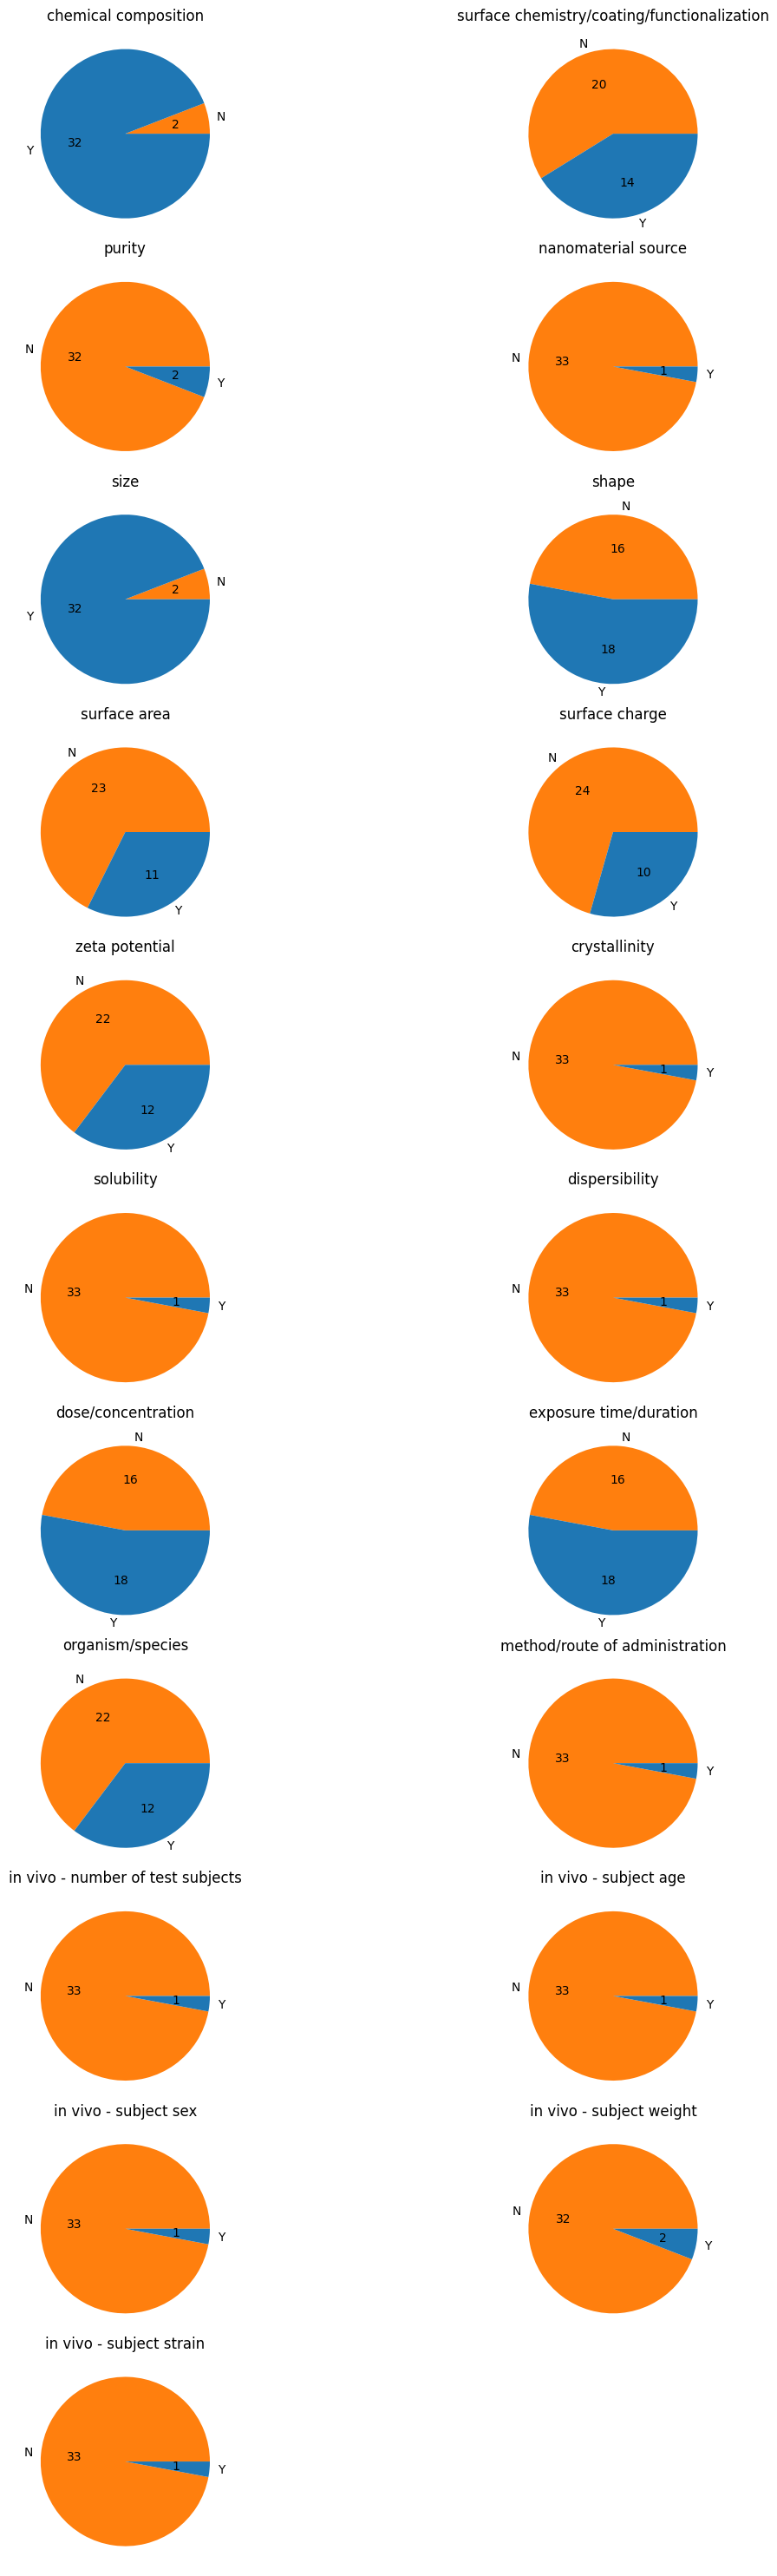

In [12]:
plt.rcParams['figure.figsize'] = [20, 20]

left  = 0.125
right = 0.3
bottom = 0.1
top = 0.9
wspace = 0.8
hspace = 0.1

colorsDict = {'Y': '#FF7F0E', 'N': '#1F77B4'}

index = 1

total = dataset_mi_matrix.shape[0]

def format_autopct(x):
    #return '{:.1f}%\n({:.0f})'.format(x, total*x/100)
    return '{:.0f}'.format(total*x/100)

plt.figure()

for i in range(1,30):
    if(len(dataset_mi_matrix.iloc[:, i].value_counts().sort_index()) == 2):
        
        plt.subplot(15,2,index)
        
        index = index + 1
        
        colorsArr = [colorsDict['Y'],colorsDict['N']]
        labelsArr = ['Y','N']
      
        plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
        dataset_mi_matrix.iloc[:, i].value_counts().sort_index().plot(kind='pie', autopct=format_autopct, colors=colorsArr, label="", figsize=(50, 50), title=dataset_mi_matrix.columns[i])


The following function creates a dictionary that keeps track of which variables are required for each of the five applications supported by the NSDRA framework.

In [13]:
def getMiAppMappingDict():
    with open('mapping.json', 'r') as f:
        miAppMapping = json.loads(f.read())
        
    app_mi_mapping = dict()
    app_mi_mapping["Grouping/Read-across"] = set()
    app_mi_mapping["Nanoform Identification"] = set()
    app_mi_mapping["Toxicity Prediction"] = set()
    app_mi_mapping["Regulatory requirements"] = set()
    app_mi_mapping["NanoInChI Calculation"] = set() 
    
    for mi in miAppMapping['abstractMIs']:
        for app in mi["related_applications"]:
            app_mi_mapping[app["name"]].add(mi["name"])
            
    return app_mi_mapping

The following function calculates how many variables required for each application are already reported by each one of the analyzed datasets

In [14]:
def getDatasetsApplicationAnnotation(dataset_mi_matrix):
    with open('mapping.json', 'r') as f:
        miAppMapping = json.loads(f.read())
    
    dataset_app_list = dict()
    
    for i, row in dataset_mi_matrix.iterrows():
    
        dataset_app_list[row['hash']] = dict()
        dataset_app_list[row['hash']]["Grouping/Read-across"] = set()
        dataset_app_list[row['hash']]["Nanoform Identification"] = set()
        dataset_app_list[row['hash']]["Toxicity Prediction"] = set()
        dataset_app_list[row['hash']]["Regulatory requirements"] = set()
        dataset_app_list[row['hash']]["NanoInChI Calculation"] = set()

        for i in range(1,31):
            if(row[dataset_mi_matrix.columns[i]] == 'Y'):
                for mi in miAppMapping['abstractMIs']:
                    for app in mi["related_applications"]:
                        if(dataset_mi_matrix.columns[i] in app_mi_mapping[app["name"]]):
                            dataset_app_list[row['hash']][app["name"]].add(dataset_mi_matrix.columns[i])
    
    return dataset_app_list

This function calculate for a given dataset (by its DOI hash) the percentage of the reported variables to the required ones for each application

In [15]:
def applicationAssessmentByDatasetHash(dsHash):
    
    data = dict()

    for i in range(0,len(dataset_app_list[dsHash])):
        app_name = list(dataset_app_list[dsHash])[i]
        app_total = len(list(app_mi_mapping[app_name]))
        app_count = len(list(dataset_app_list[dsHash].values())[i])
        data[app_name] = app_count/app_total
        
    return data

This function creates a plot for the coverage percentage of reported variables for each application for a given dataset

In [16]:
def plotDatasetApplicationAssessment(dsHash):
    
    data = applicationAssessmentByDatasetHash(dsHash)
    apps = list(data.keys())
    values = list(data.values())

    fig = plt.figure(figsize = (12, 5))

    plt.bar(apps, values, color ='maroon', width = 0.4)

    plt.xlabel("Reusability applications")
    plt.ylabel("Coverage percentage")
    plt.ylim(0.0, 1.1)
    plt.title(dataset_desc[dataset_desc.hash == dsHash].iloc[0]["title"][0:100]+" ...")
    plt.show()

In [17]:
app_mi_mapping = getMiAppMappingDict()

In [18]:
dataset_app_list = getDatasetsApplicationAnnotation(dataset_mi_matrix)

In [19]:
app_mi_mapping["NanoInChI Calculation"]

{'chemical composition', 'crystallinity', 'shape', 'size'}

In [20]:
len(dataset_app_list)

34

In [21]:
dataset_app_list["9e1d426c9015fc15d718b0fbd3f41152"]

{'Grouping/Read-across': {'chemical composition',
  'shape',
  'size',
  'surface chemistry/coating/functionalization',
  'zeta potential'},
 'Nanoform Identification': {'chemical composition',
  'shape',
  'size',
  'surface chemistry/coating/functionalization'},
 'Toxicity Prediction': {'chemical composition',
  'shape',
  'size',
  'surface chemistry/coating/functionalization',
  'zeta potential'},
 'Regulatory requirements': {'chemical composition',
  'shape',
  'size',
  'surface chemistry/coating/functionalization',
  'zeta potential'},
 'NanoInChI Calculation': {'chemical composition', 'shape', 'size'}}

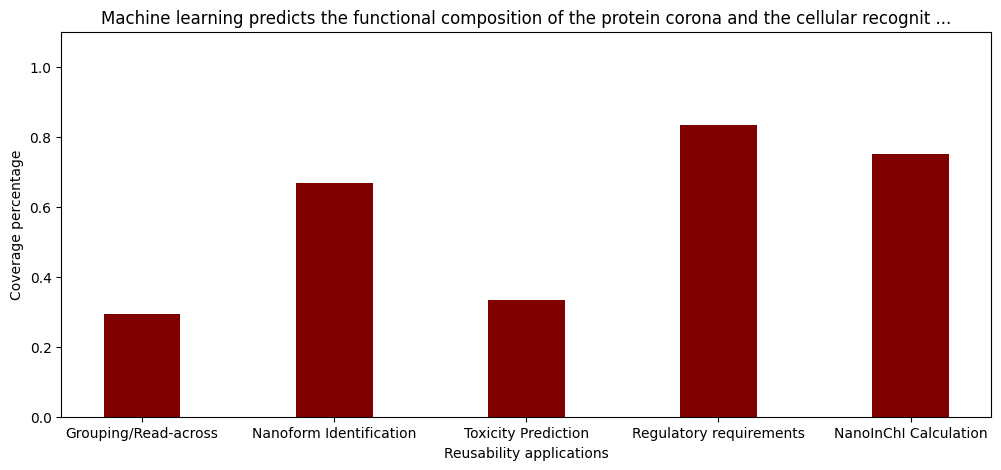

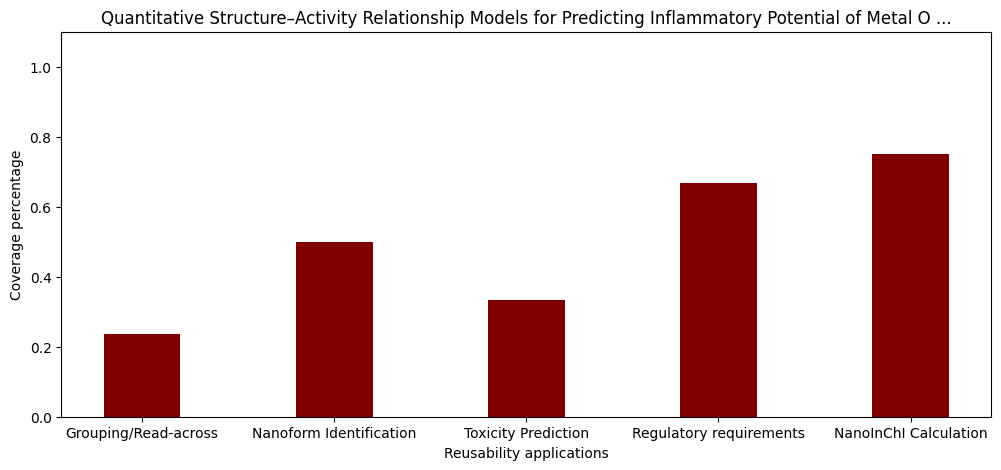

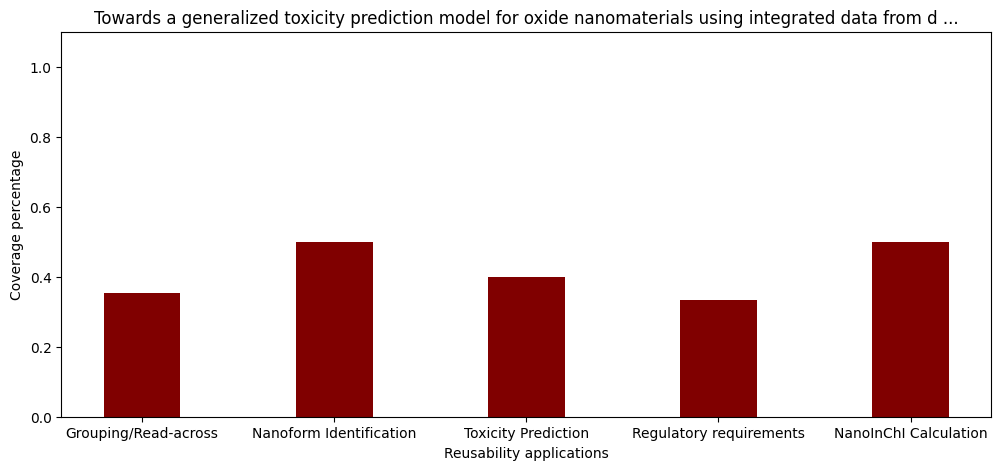

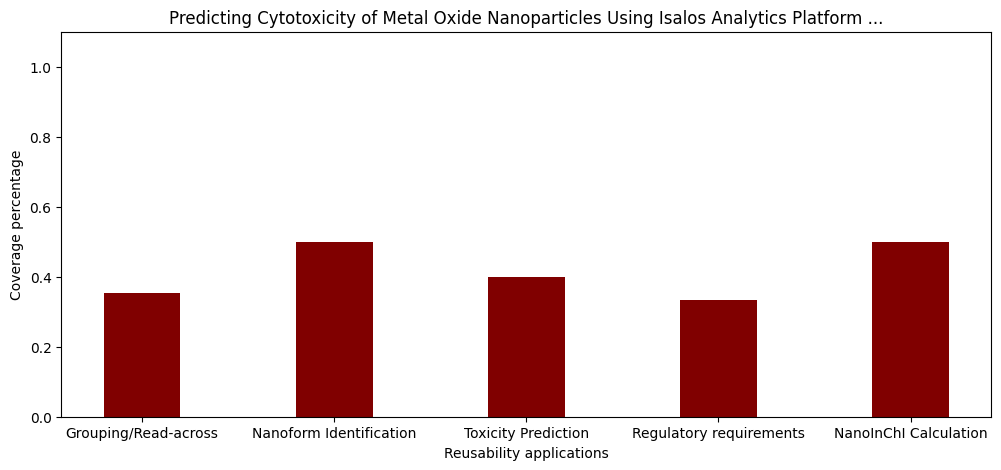

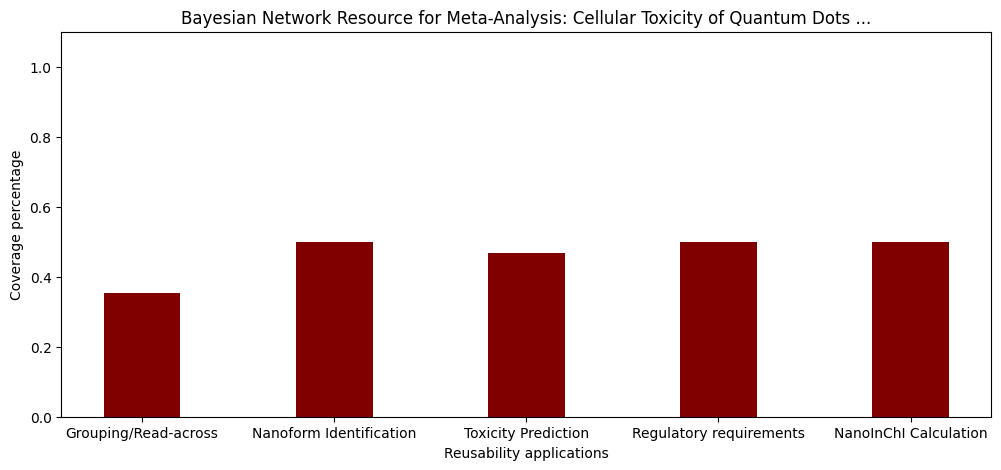

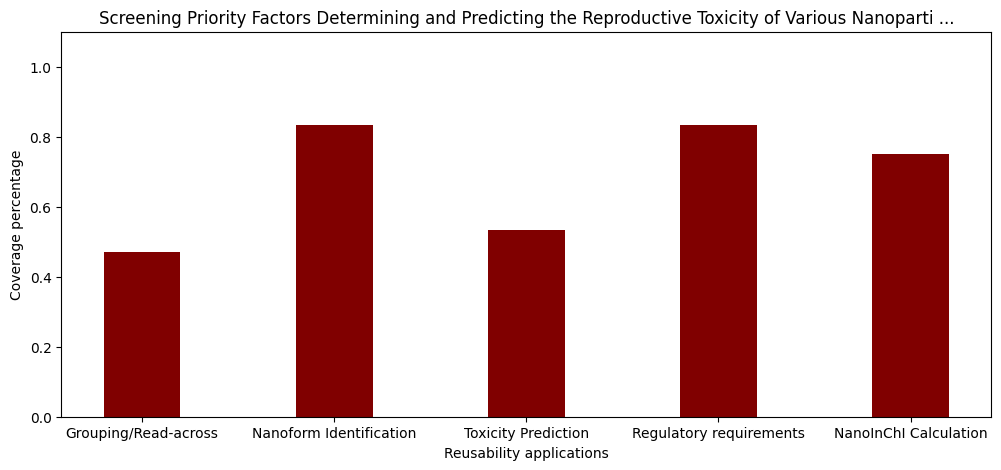

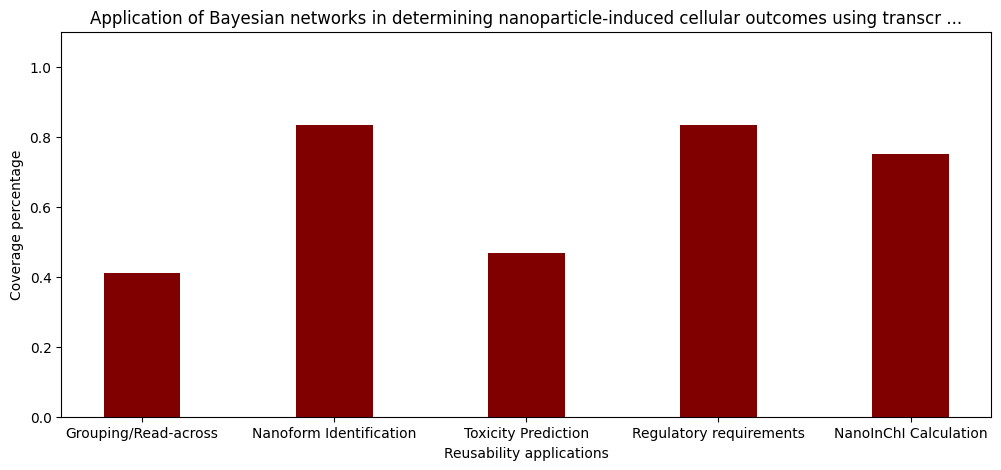

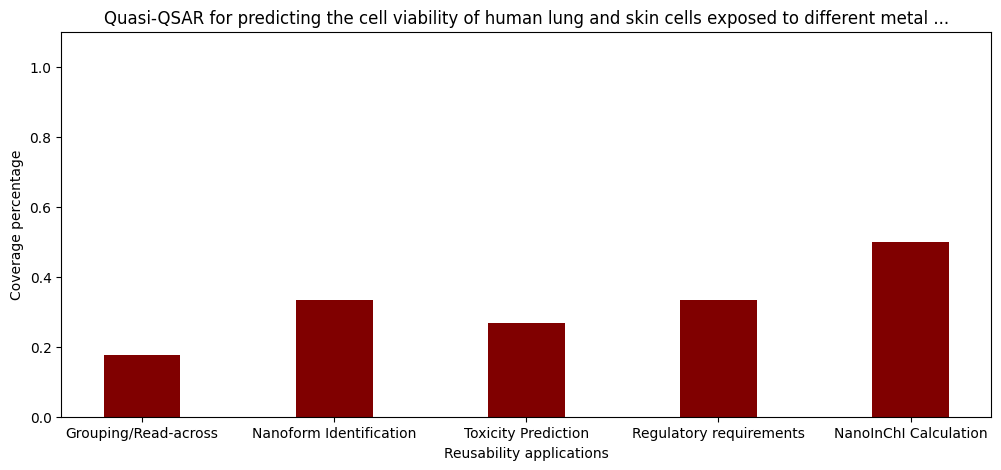

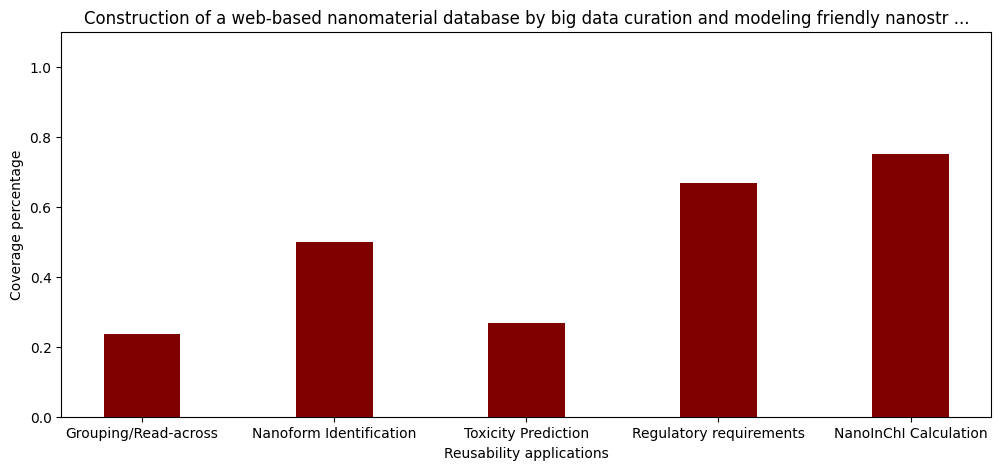

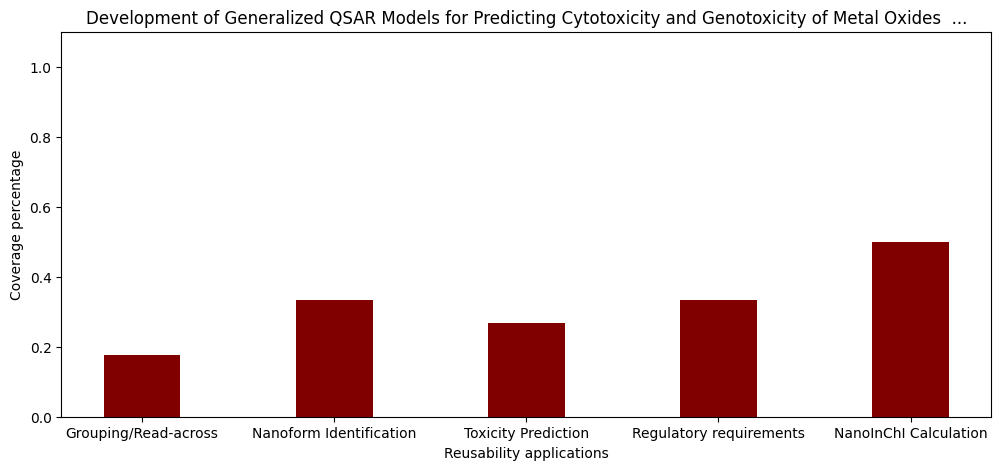

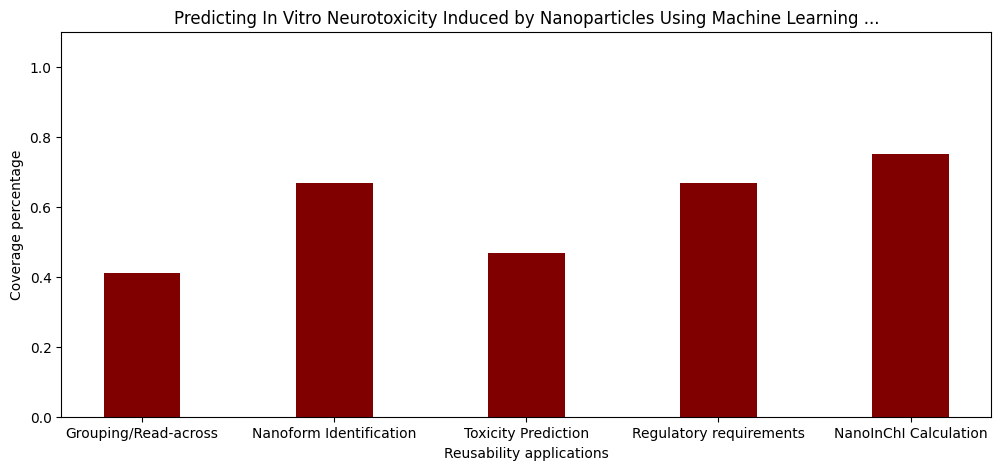

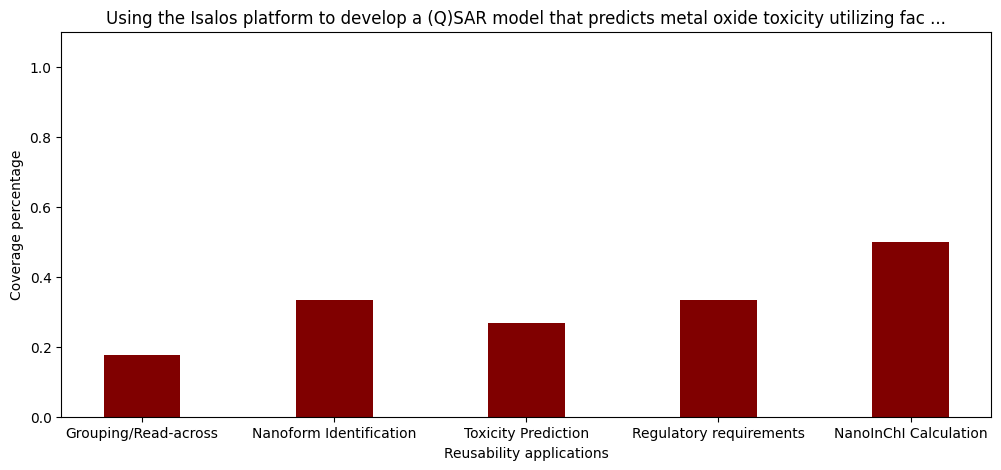

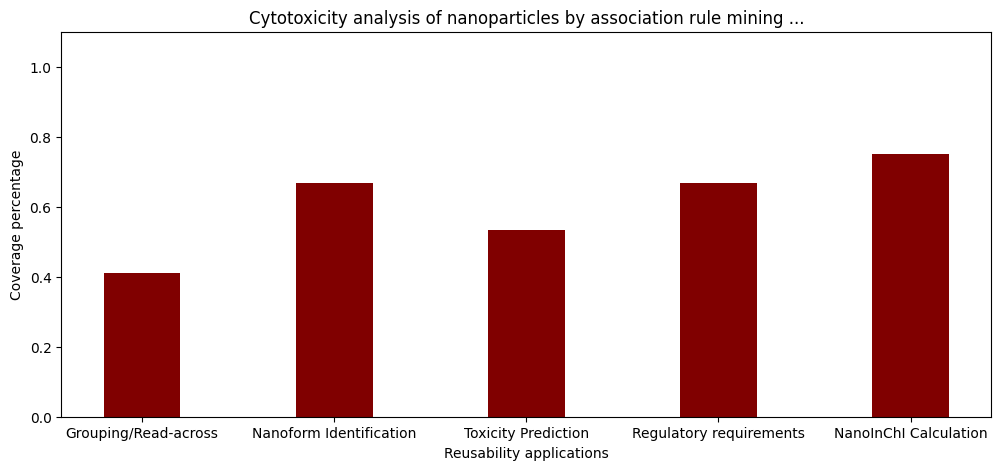

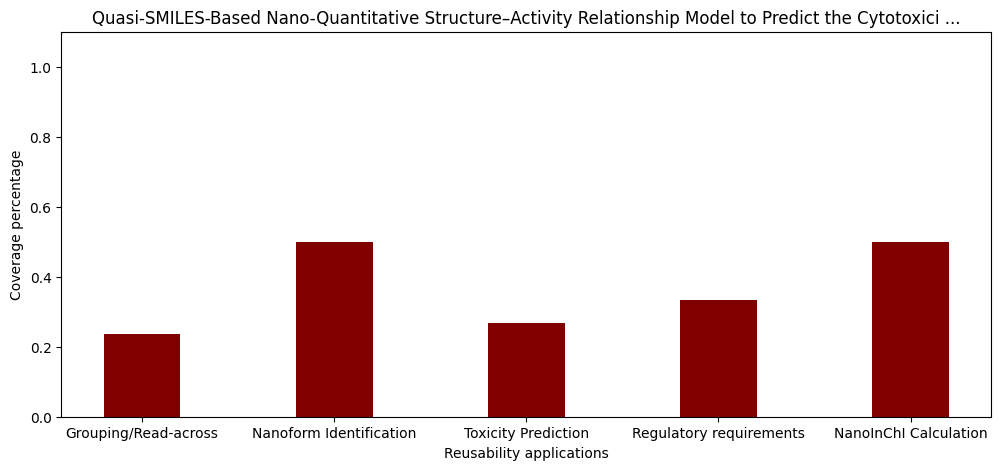

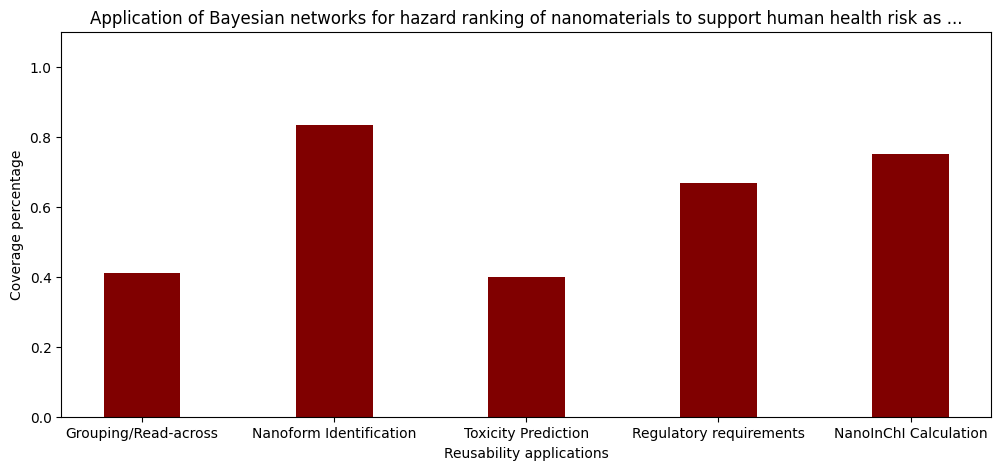

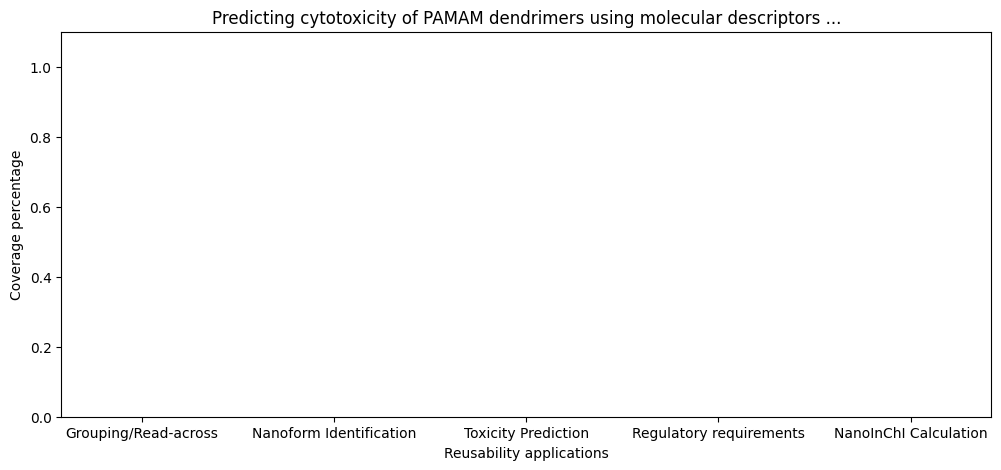

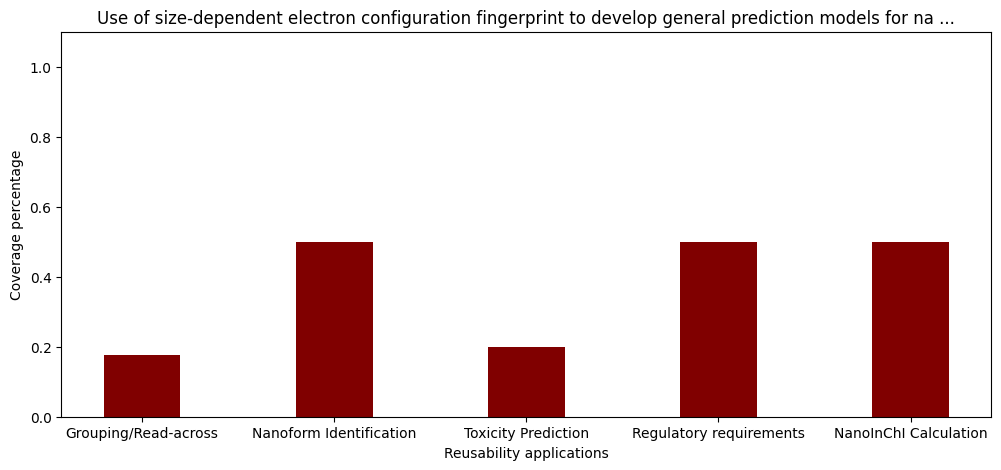

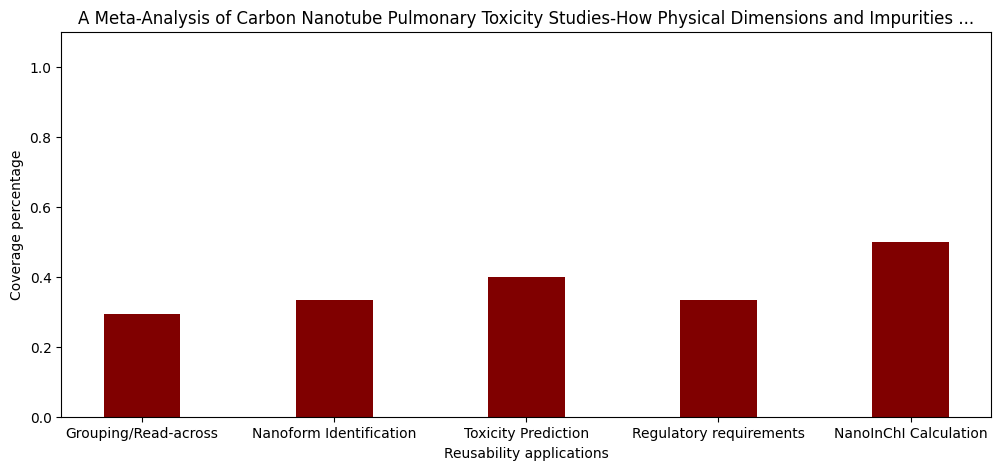

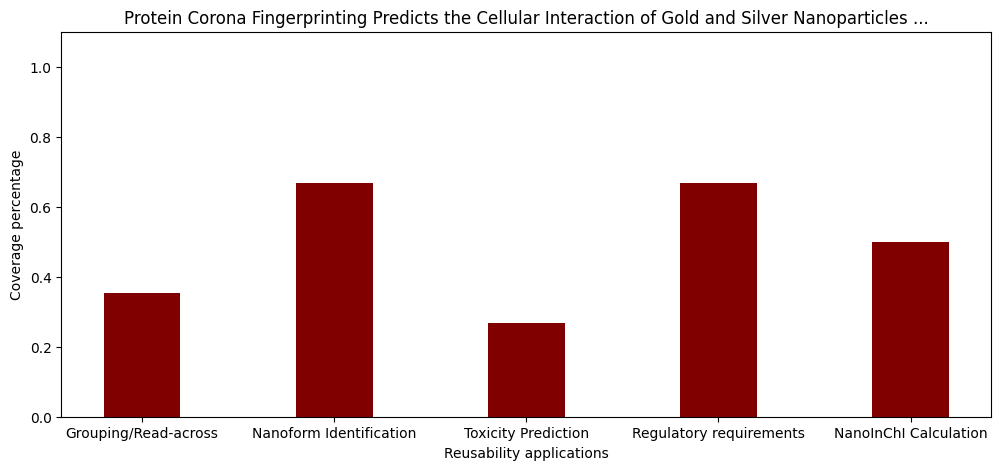

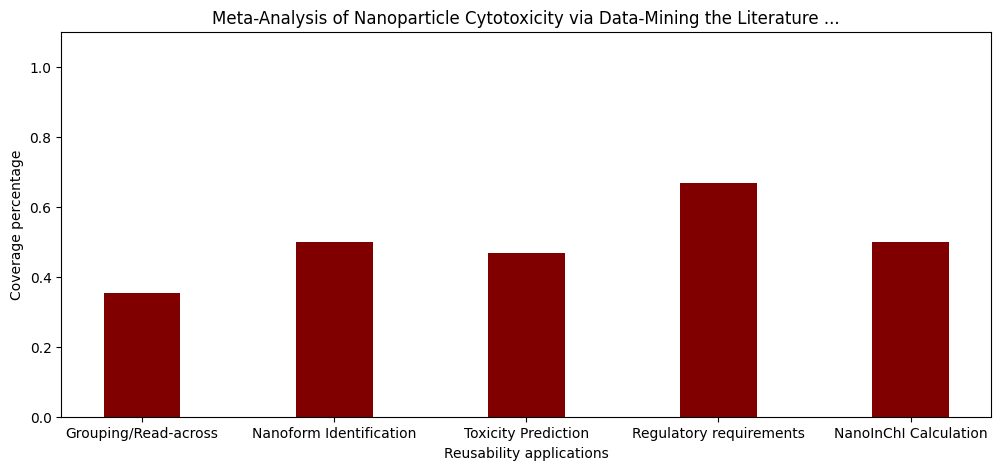

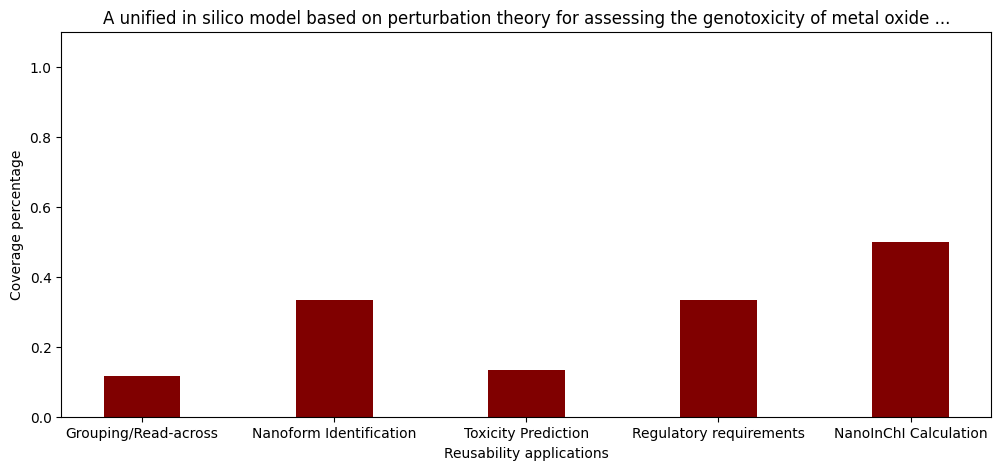

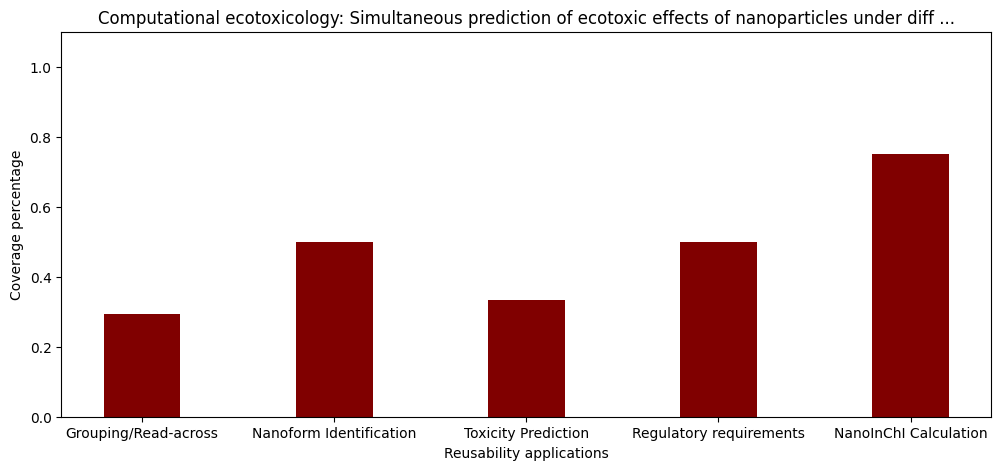

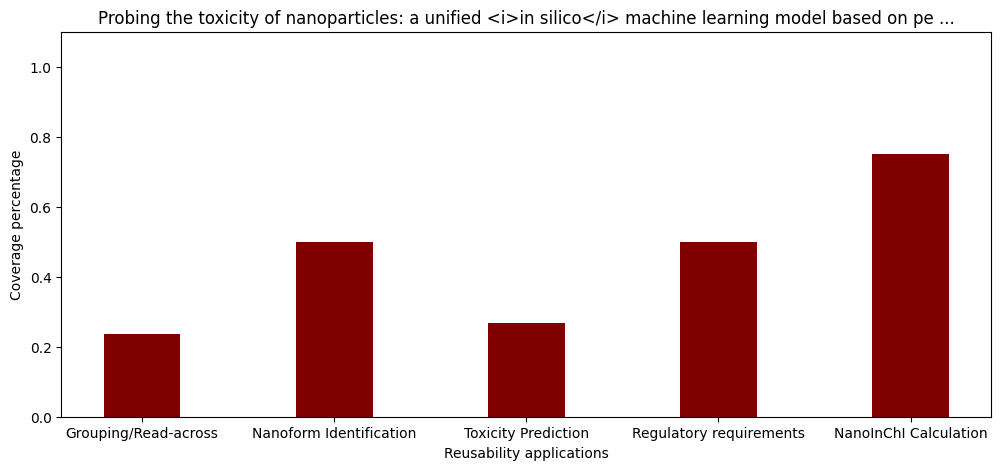

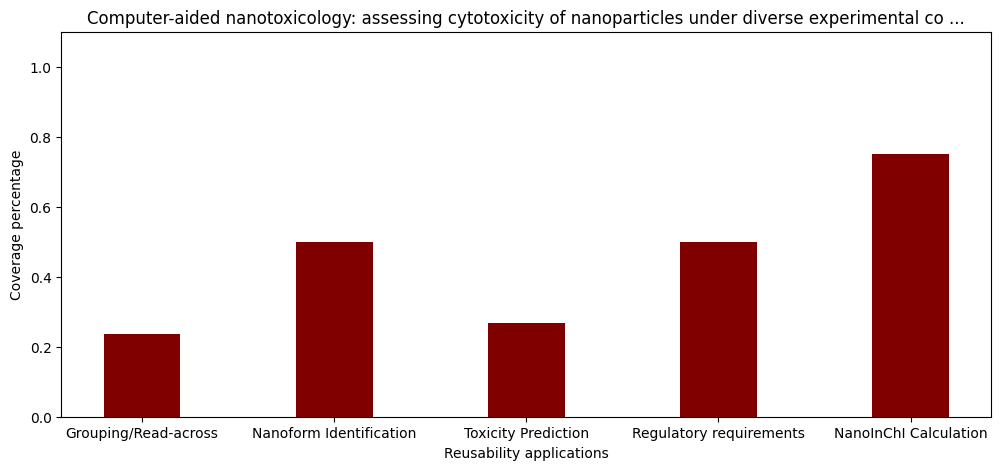

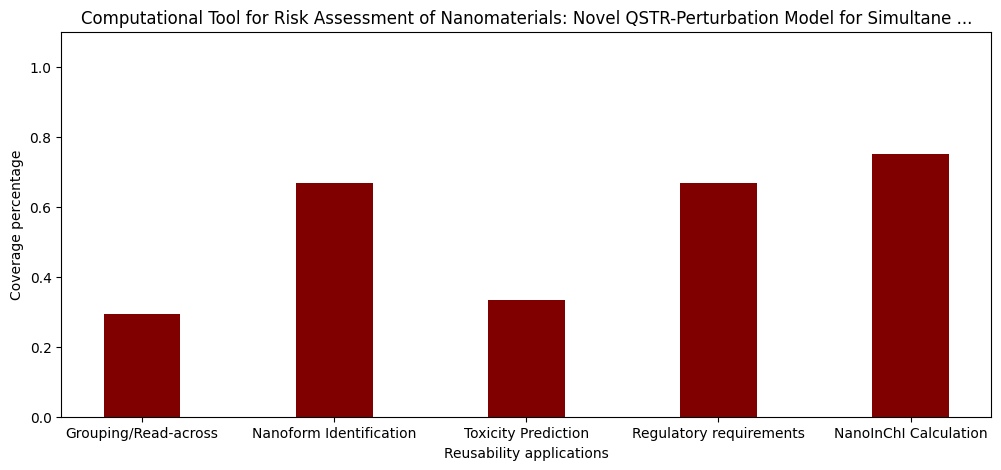

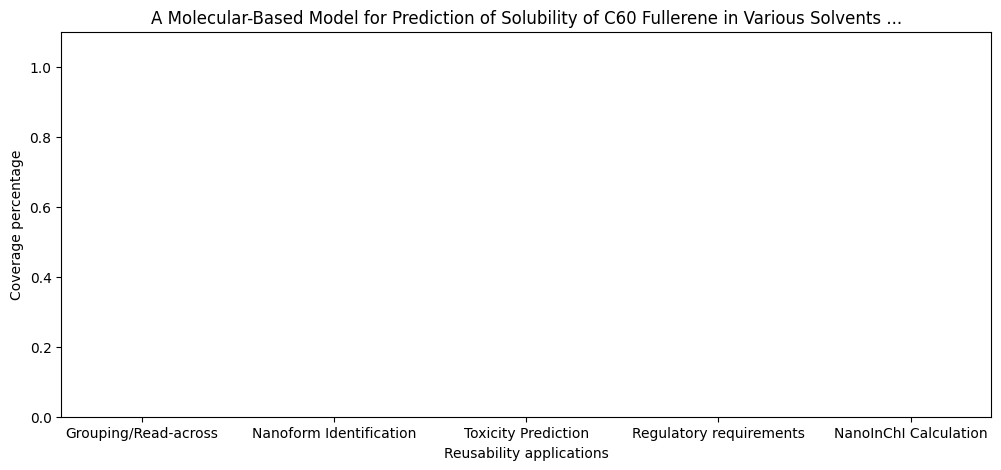

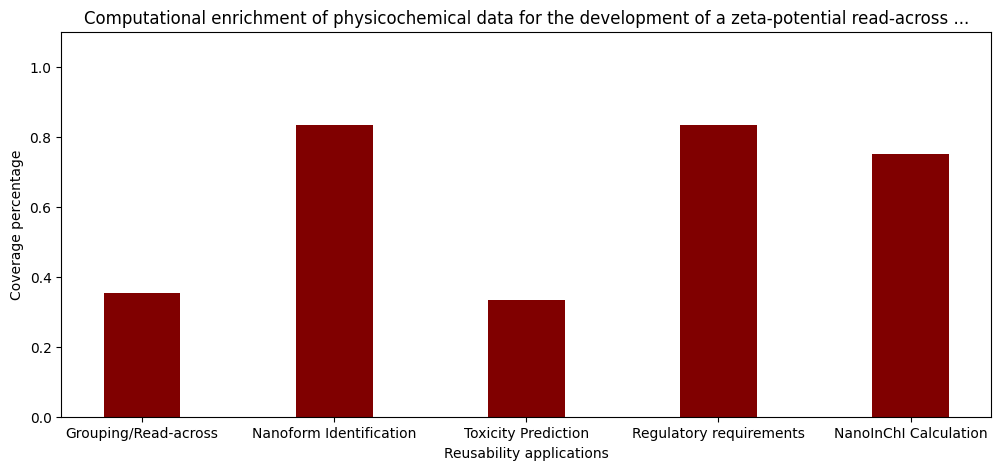

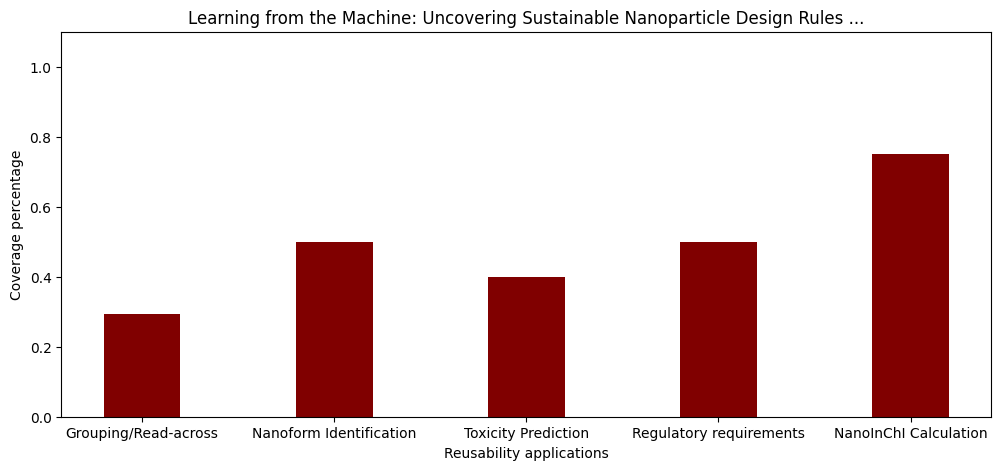

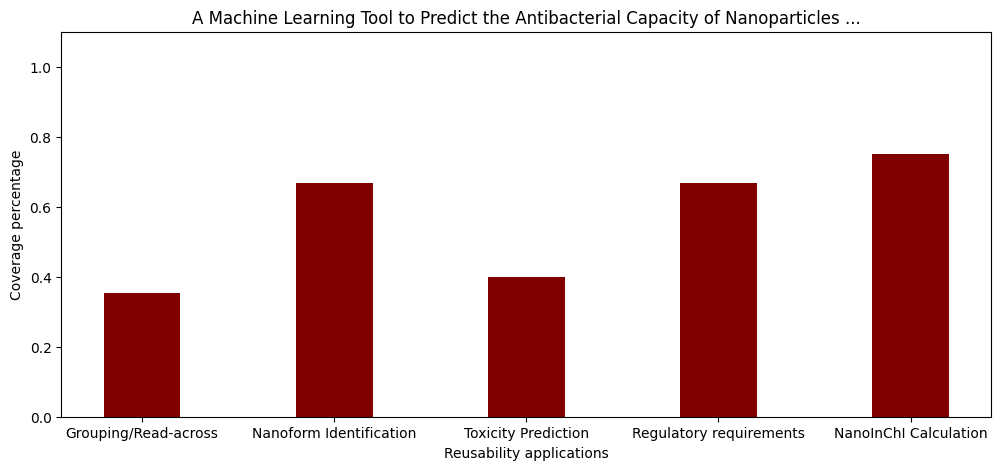

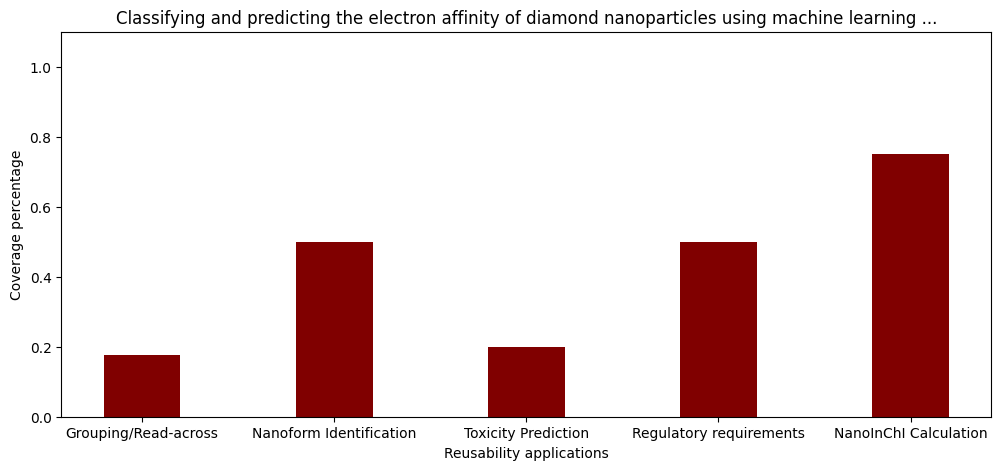

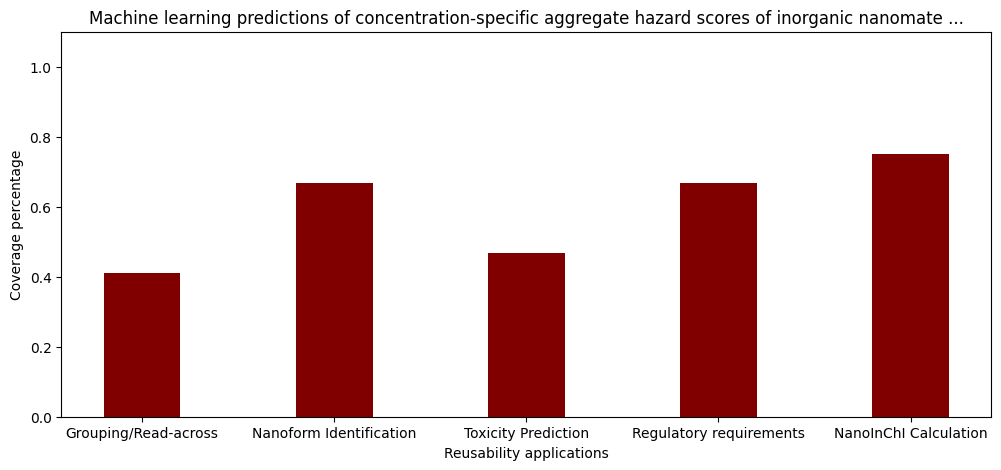

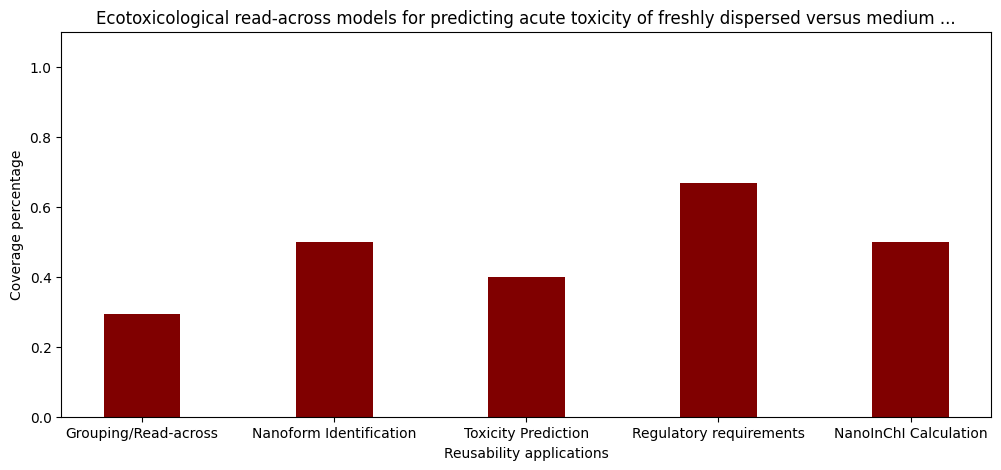

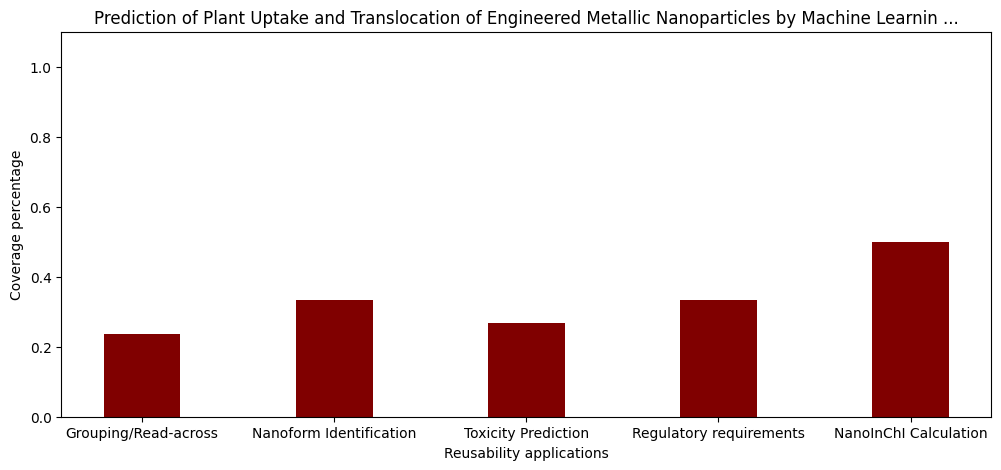

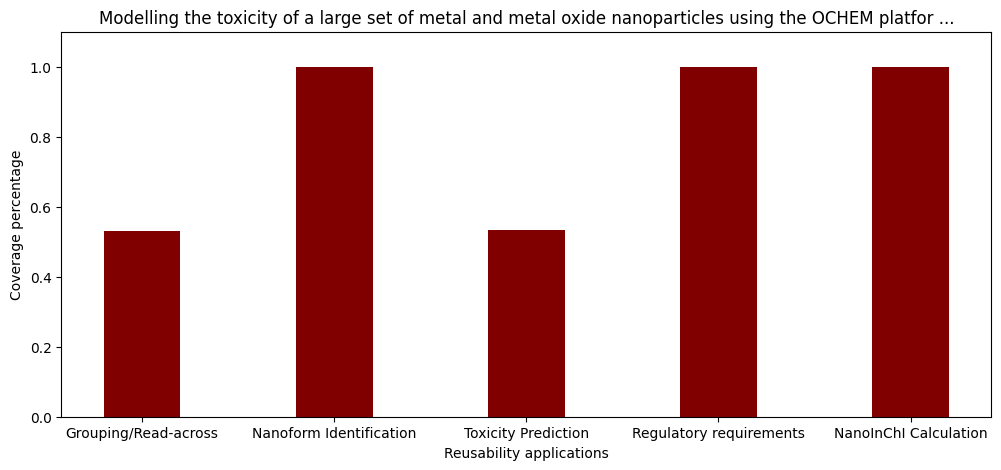

In [22]:
for i, row in dataset_mi_matrix.iterrows():
    plotDatasetApplicationAssessment(row["hash"])

In [23]:
data_list = list()

for i, row in dataset_mi_matrix.iterrows():
    
    data = applicationAssessmentByDatasetHash(row["hash"])
    
    tmp = list(data.values())
    tmp.append(row["hash"])
    
    data_list.append(tmp)   
    
    

In [24]:
data_df = pd.DataFrame(data_list, 
                  columns = ['Grouping/Read-across', 'Nanoform Identification', 'Toxicity Prediction',
                            'Regulatory requirements', 'NanoInChI Calculation', 'hash'])

In [25]:
data_df = data_df.merge(dataset_desc, on='hash')

In [26]:
applications = ['Grouping/Read-across', 'Nanoform Identification', 'Toxicity Prediction',
                            'Regulatory requirements', 'NanoInChI Calculation']

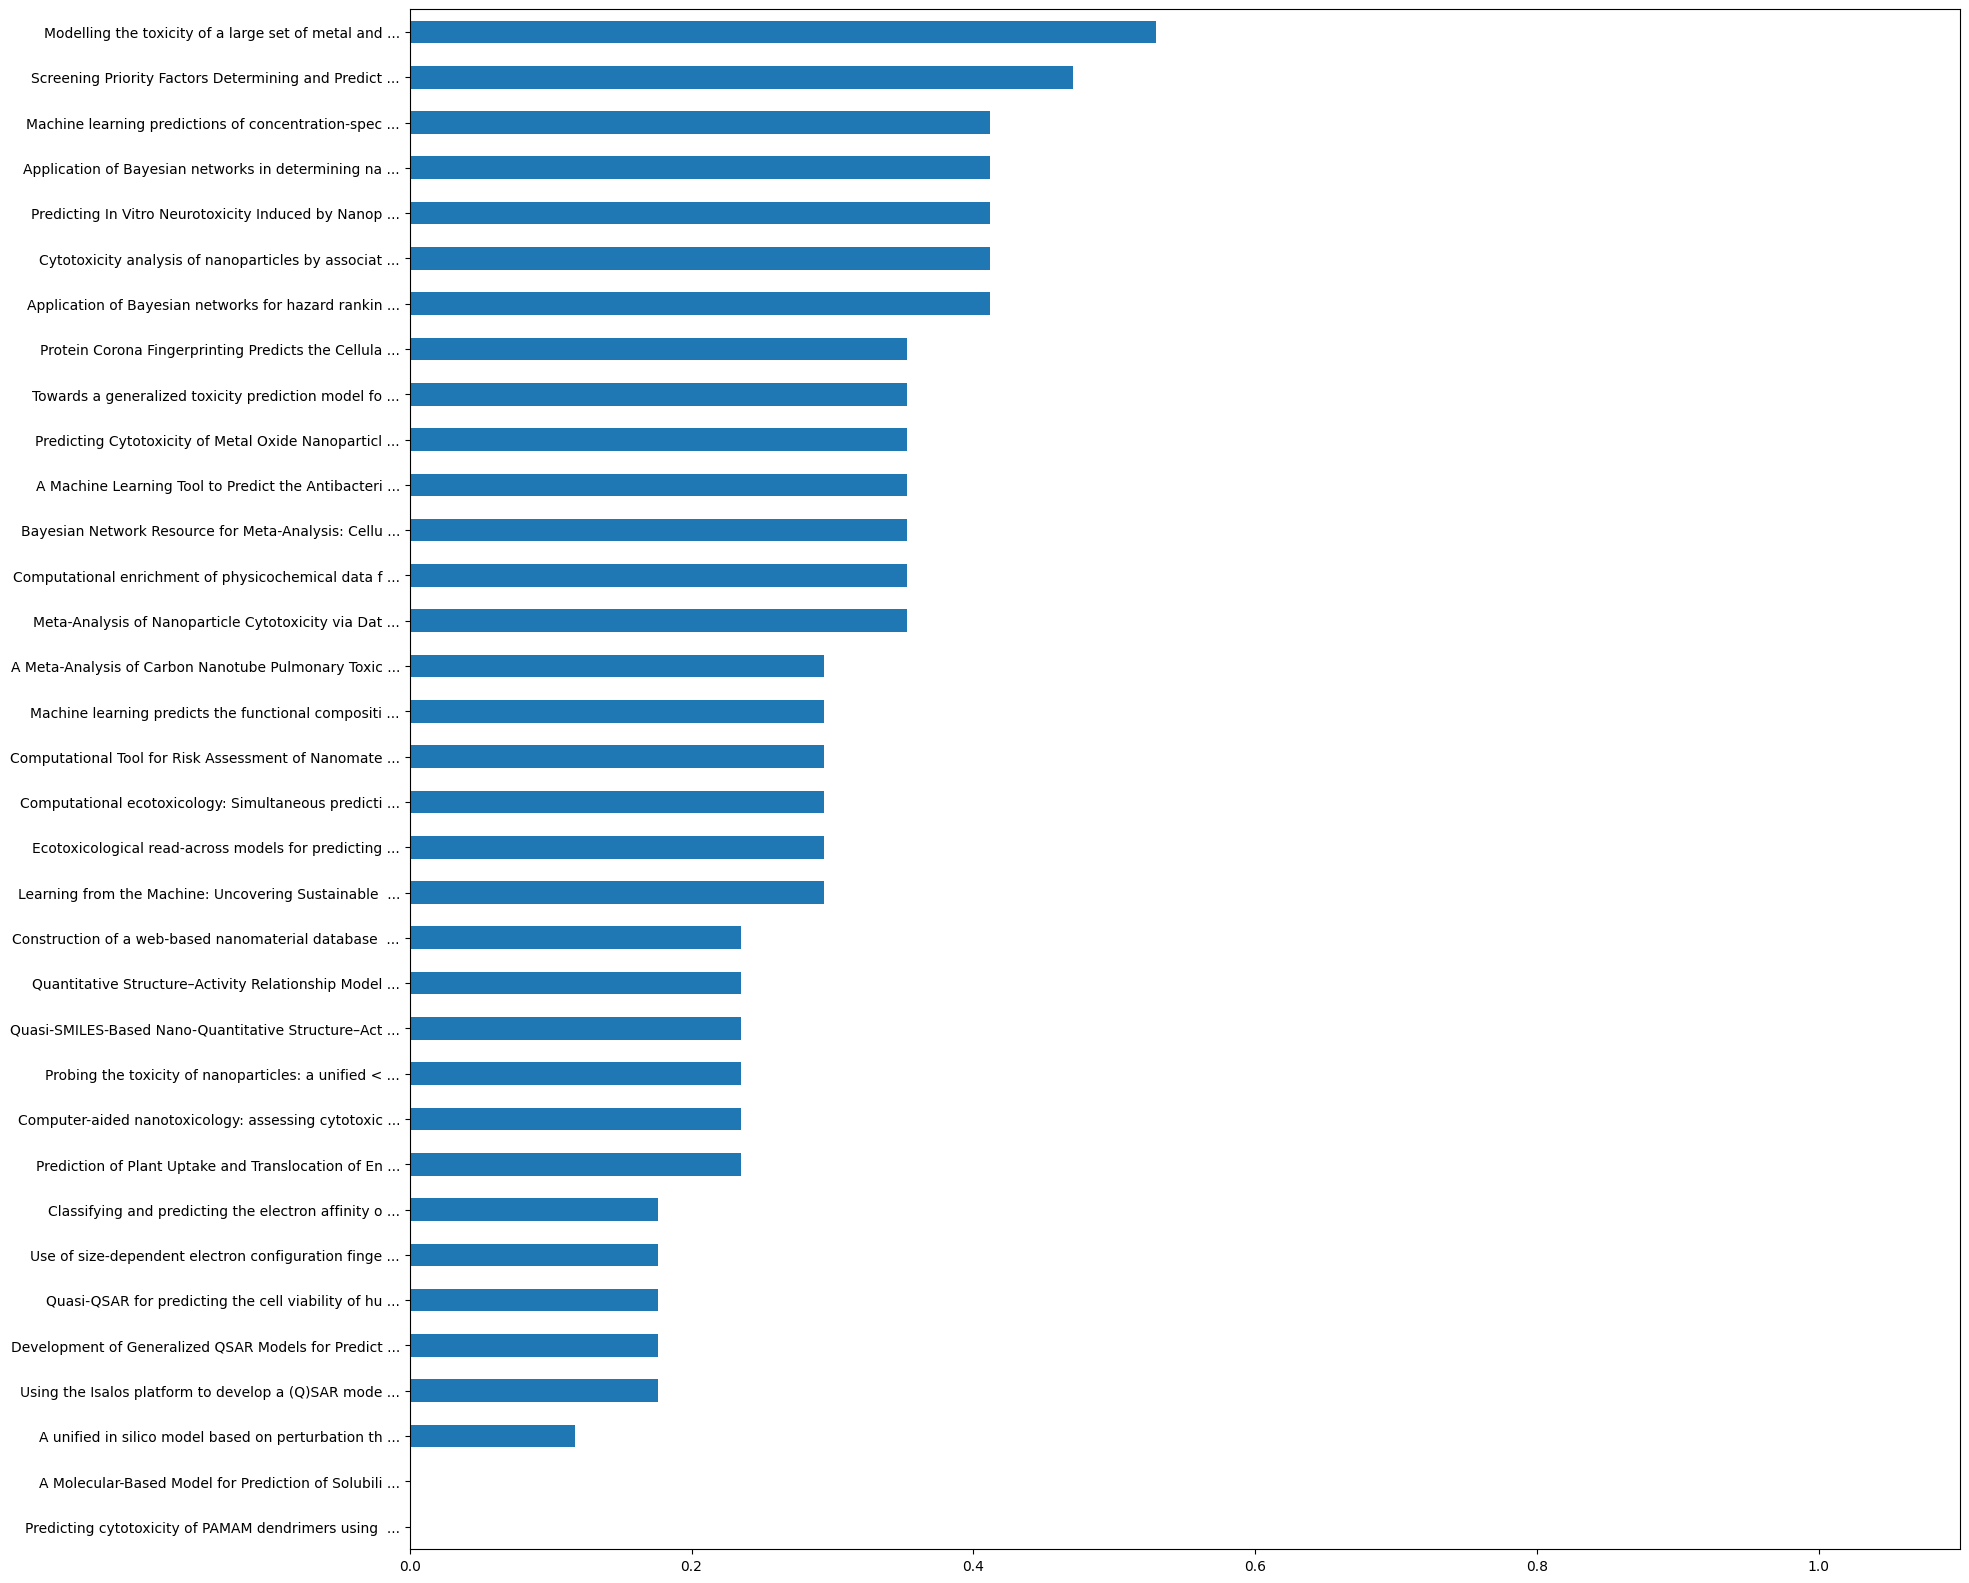

In [27]:
ax = data_df[applications[0]].sort_values().plot(kind='barh', xlim=(0.0, 1.1))
_ = ax.set_yticklabels(data_df.sort_values(applications[0])['title'].str[0:50]+" ...")


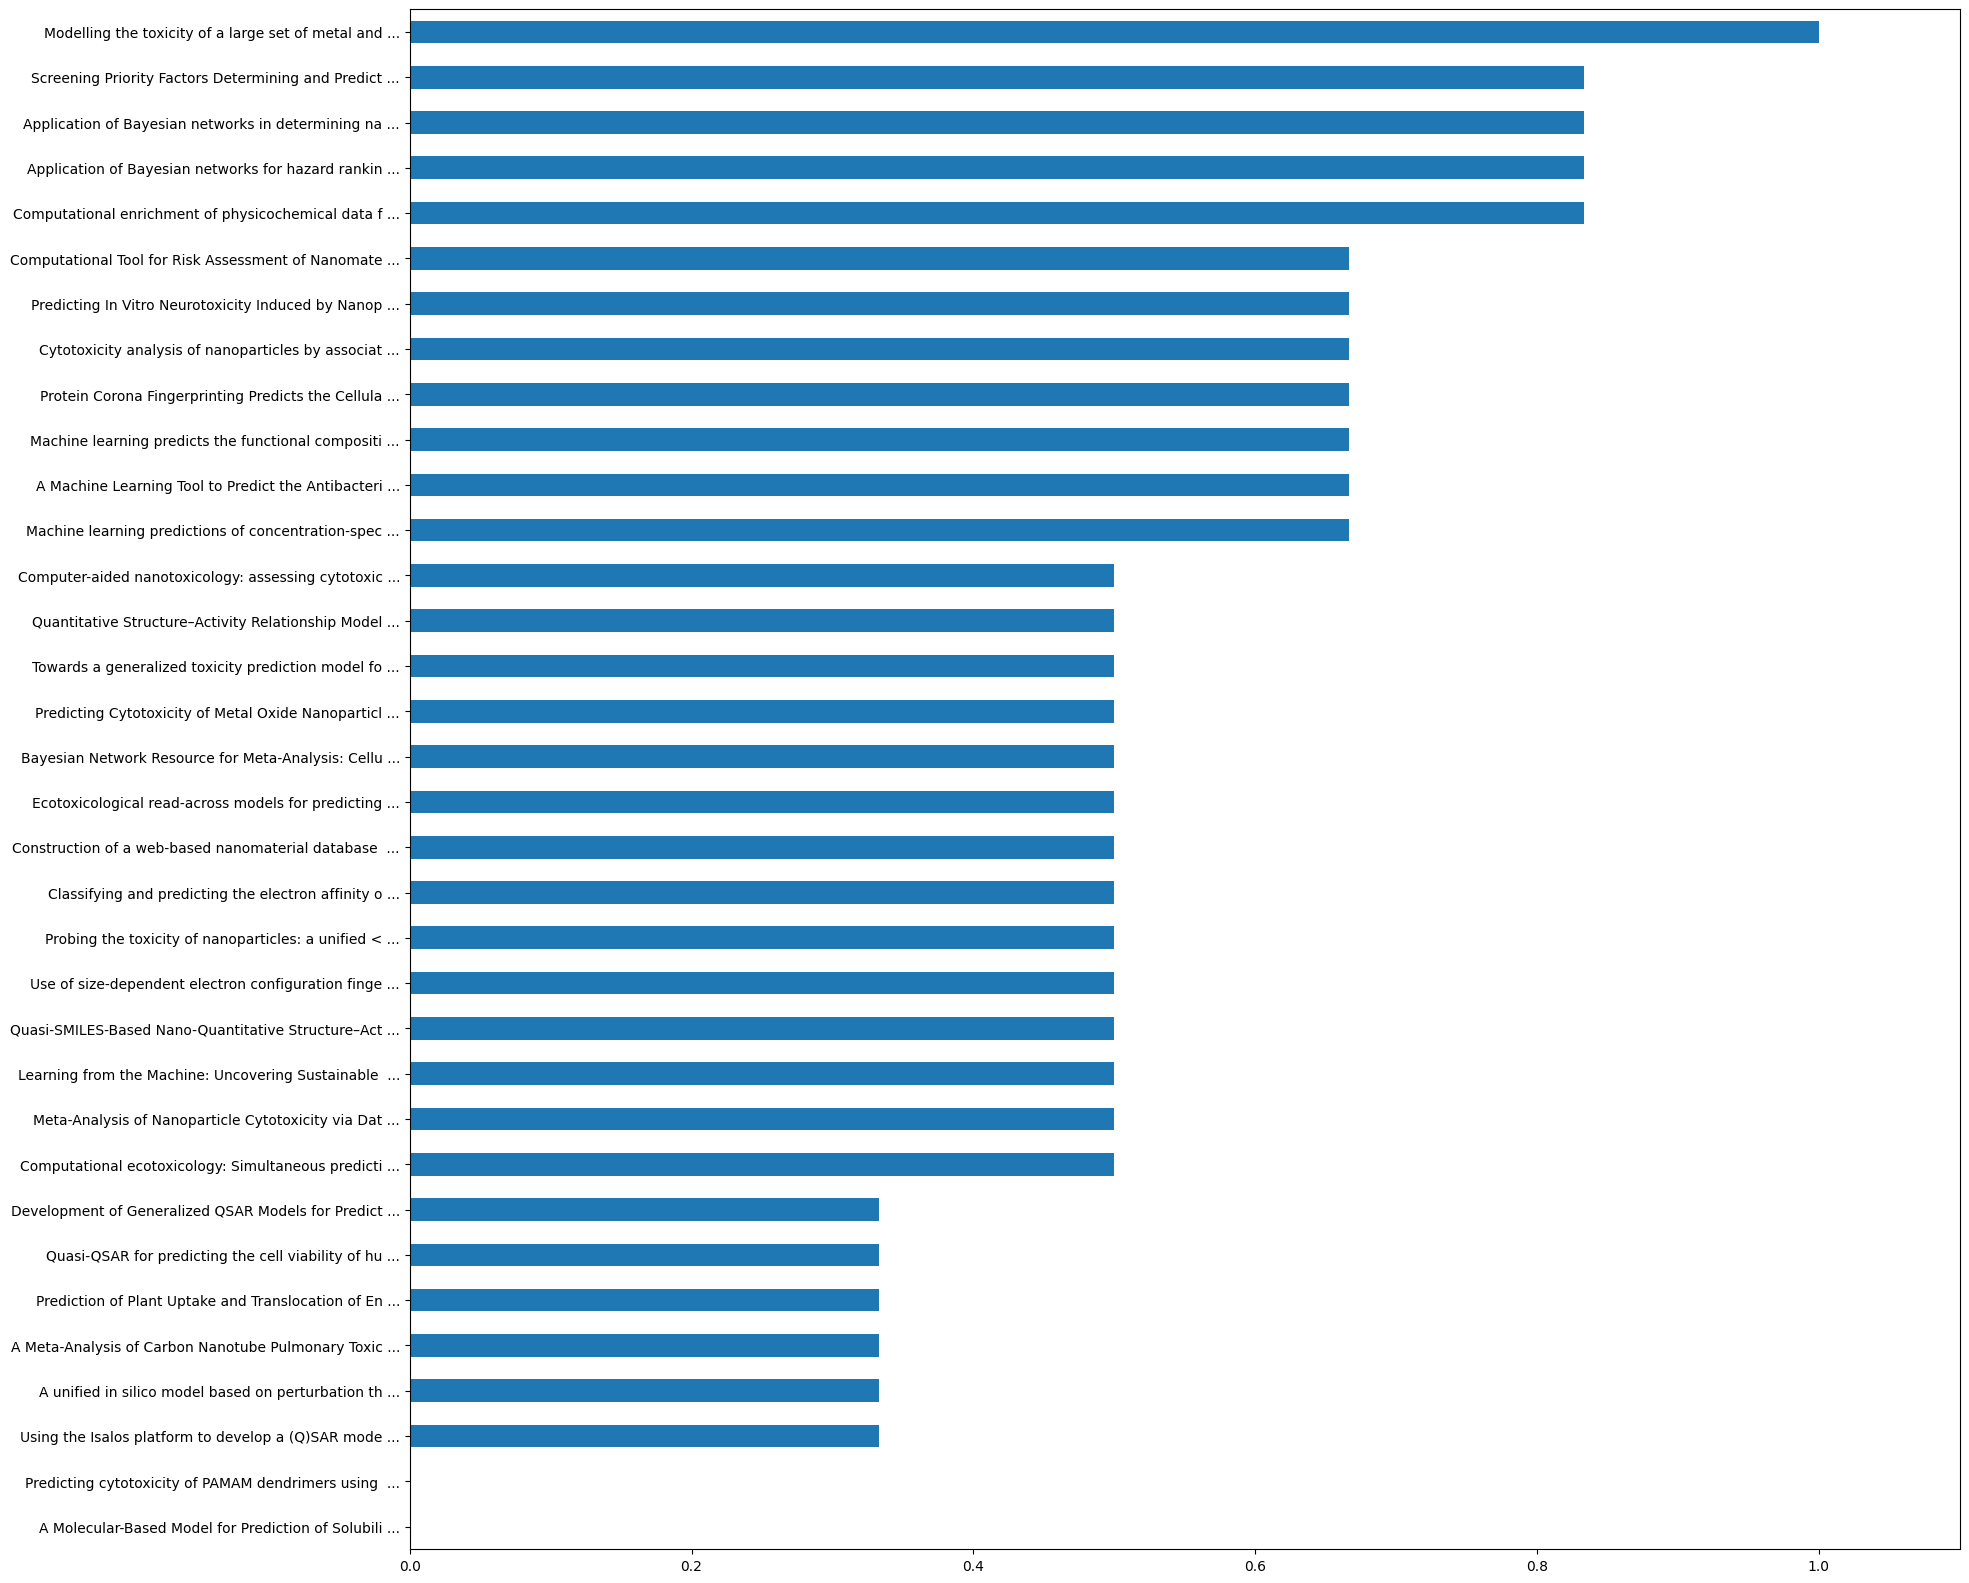

In [28]:
ax = data_df[applications[1]].sort_values().plot(kind='barh', xlim=(0.0, 1.1))
_ = ax.set_yticklabels(data_df.sort_values(applications[1])['title'].str[0:50]+" ...")

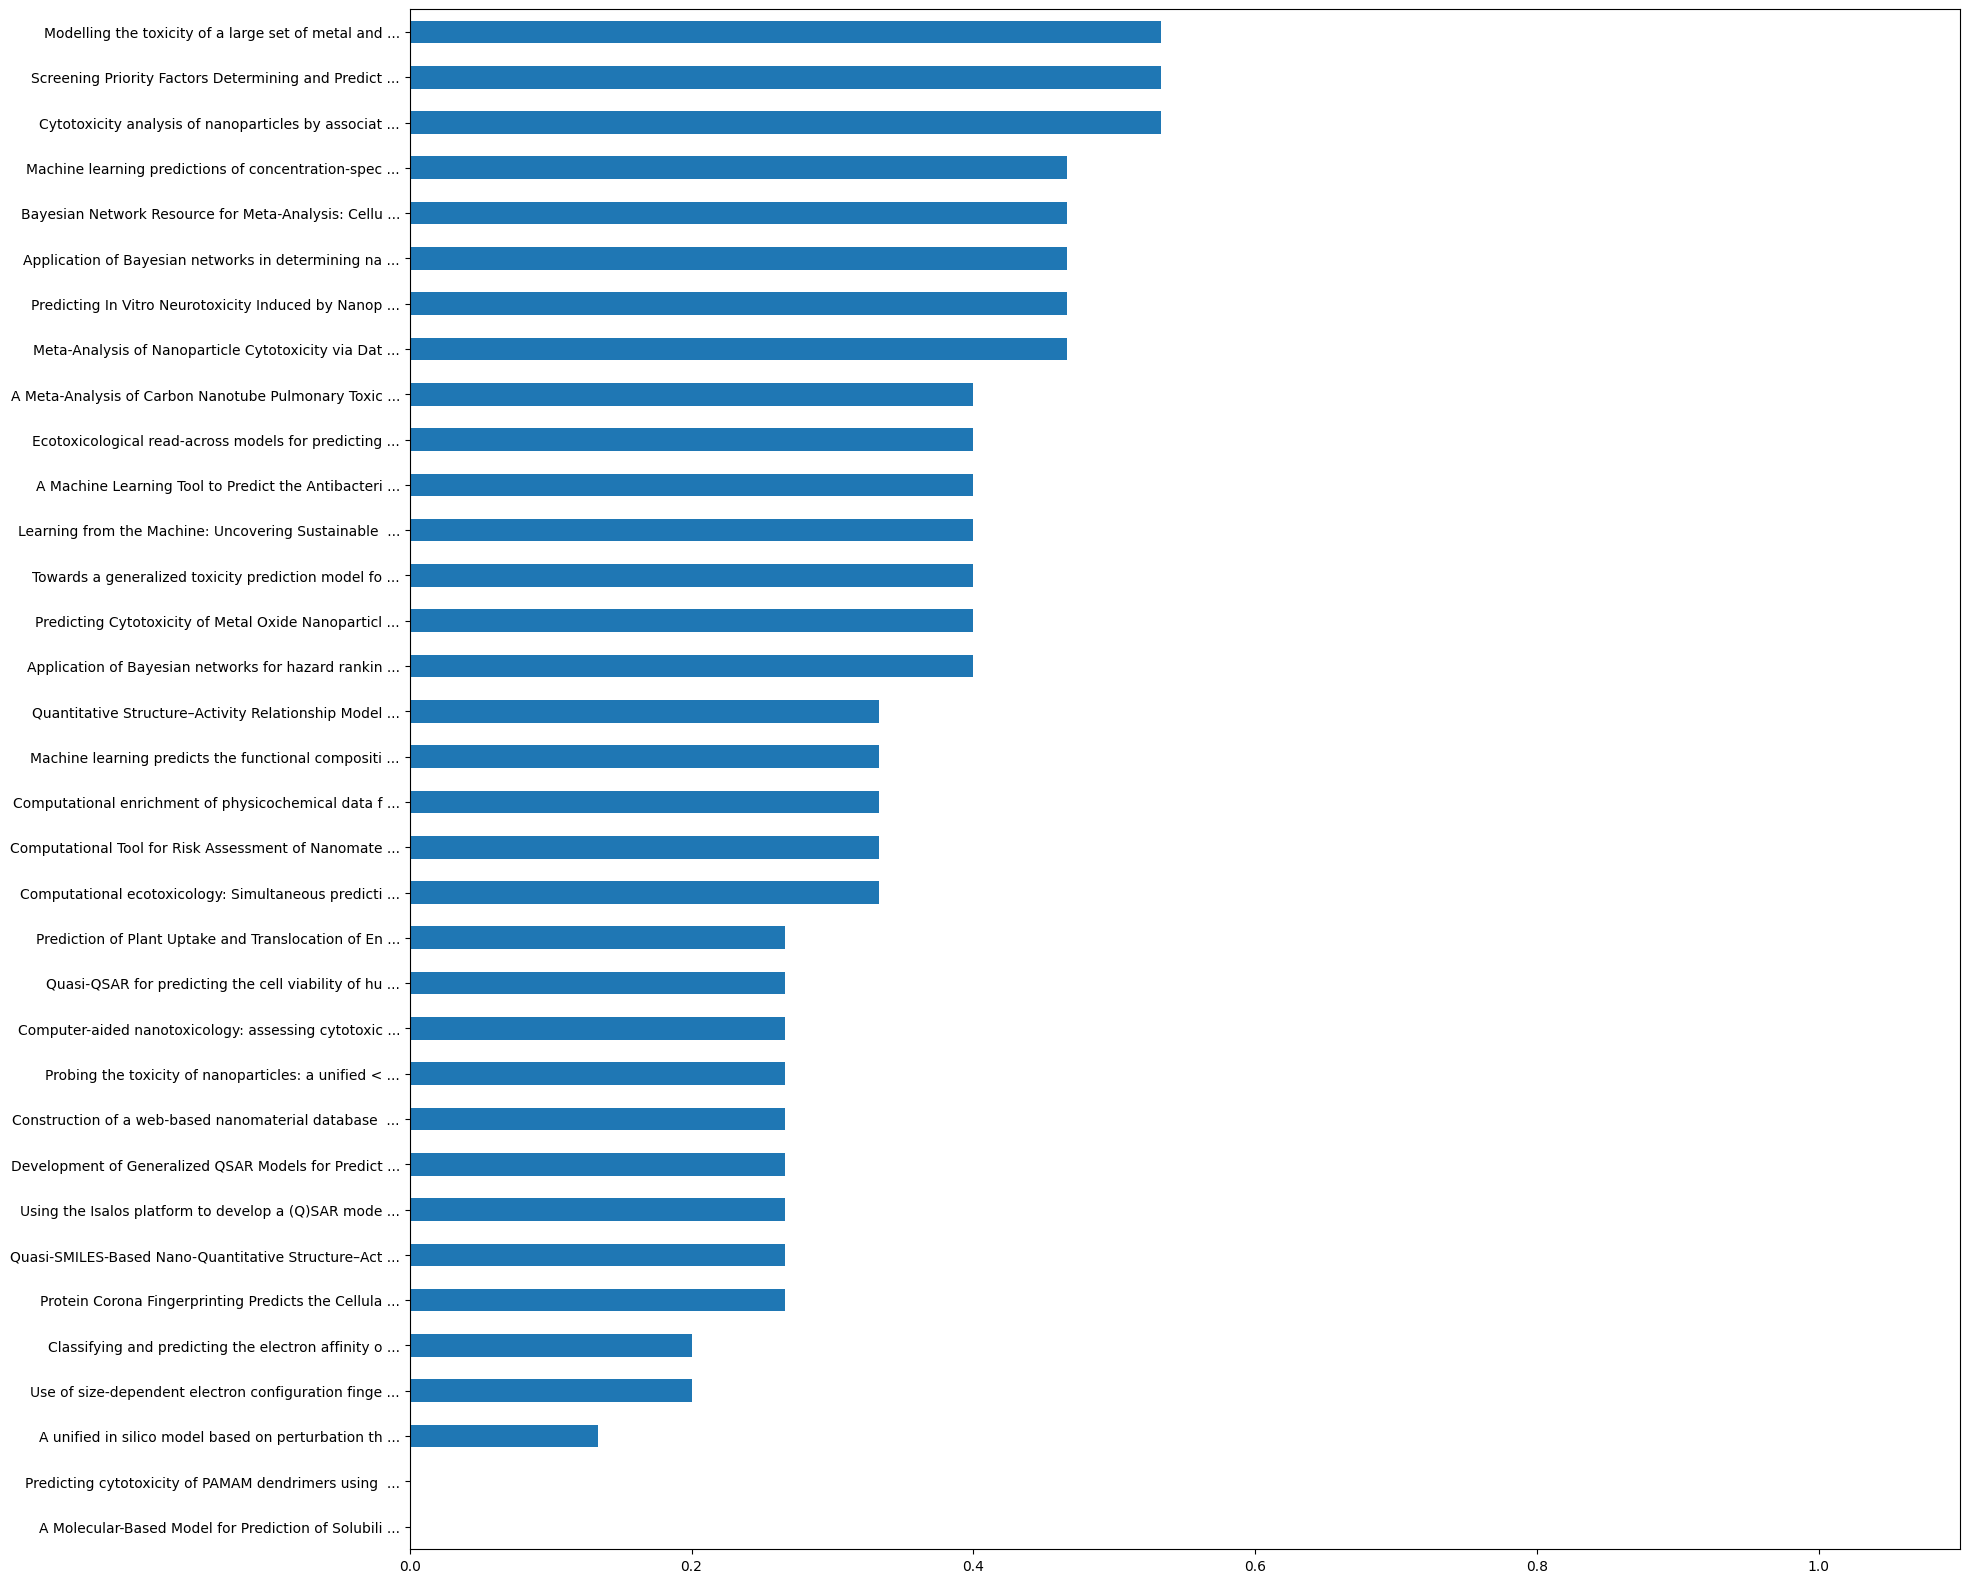

In [29]:
ax = data_df[applications[2]].sort_values().plot(kind='barh', xlim=(0.0, 1.1))
_ = ax.set_yticklabels(data_df.sort_values(applications[2])['title'].str[0:50]+" ...")

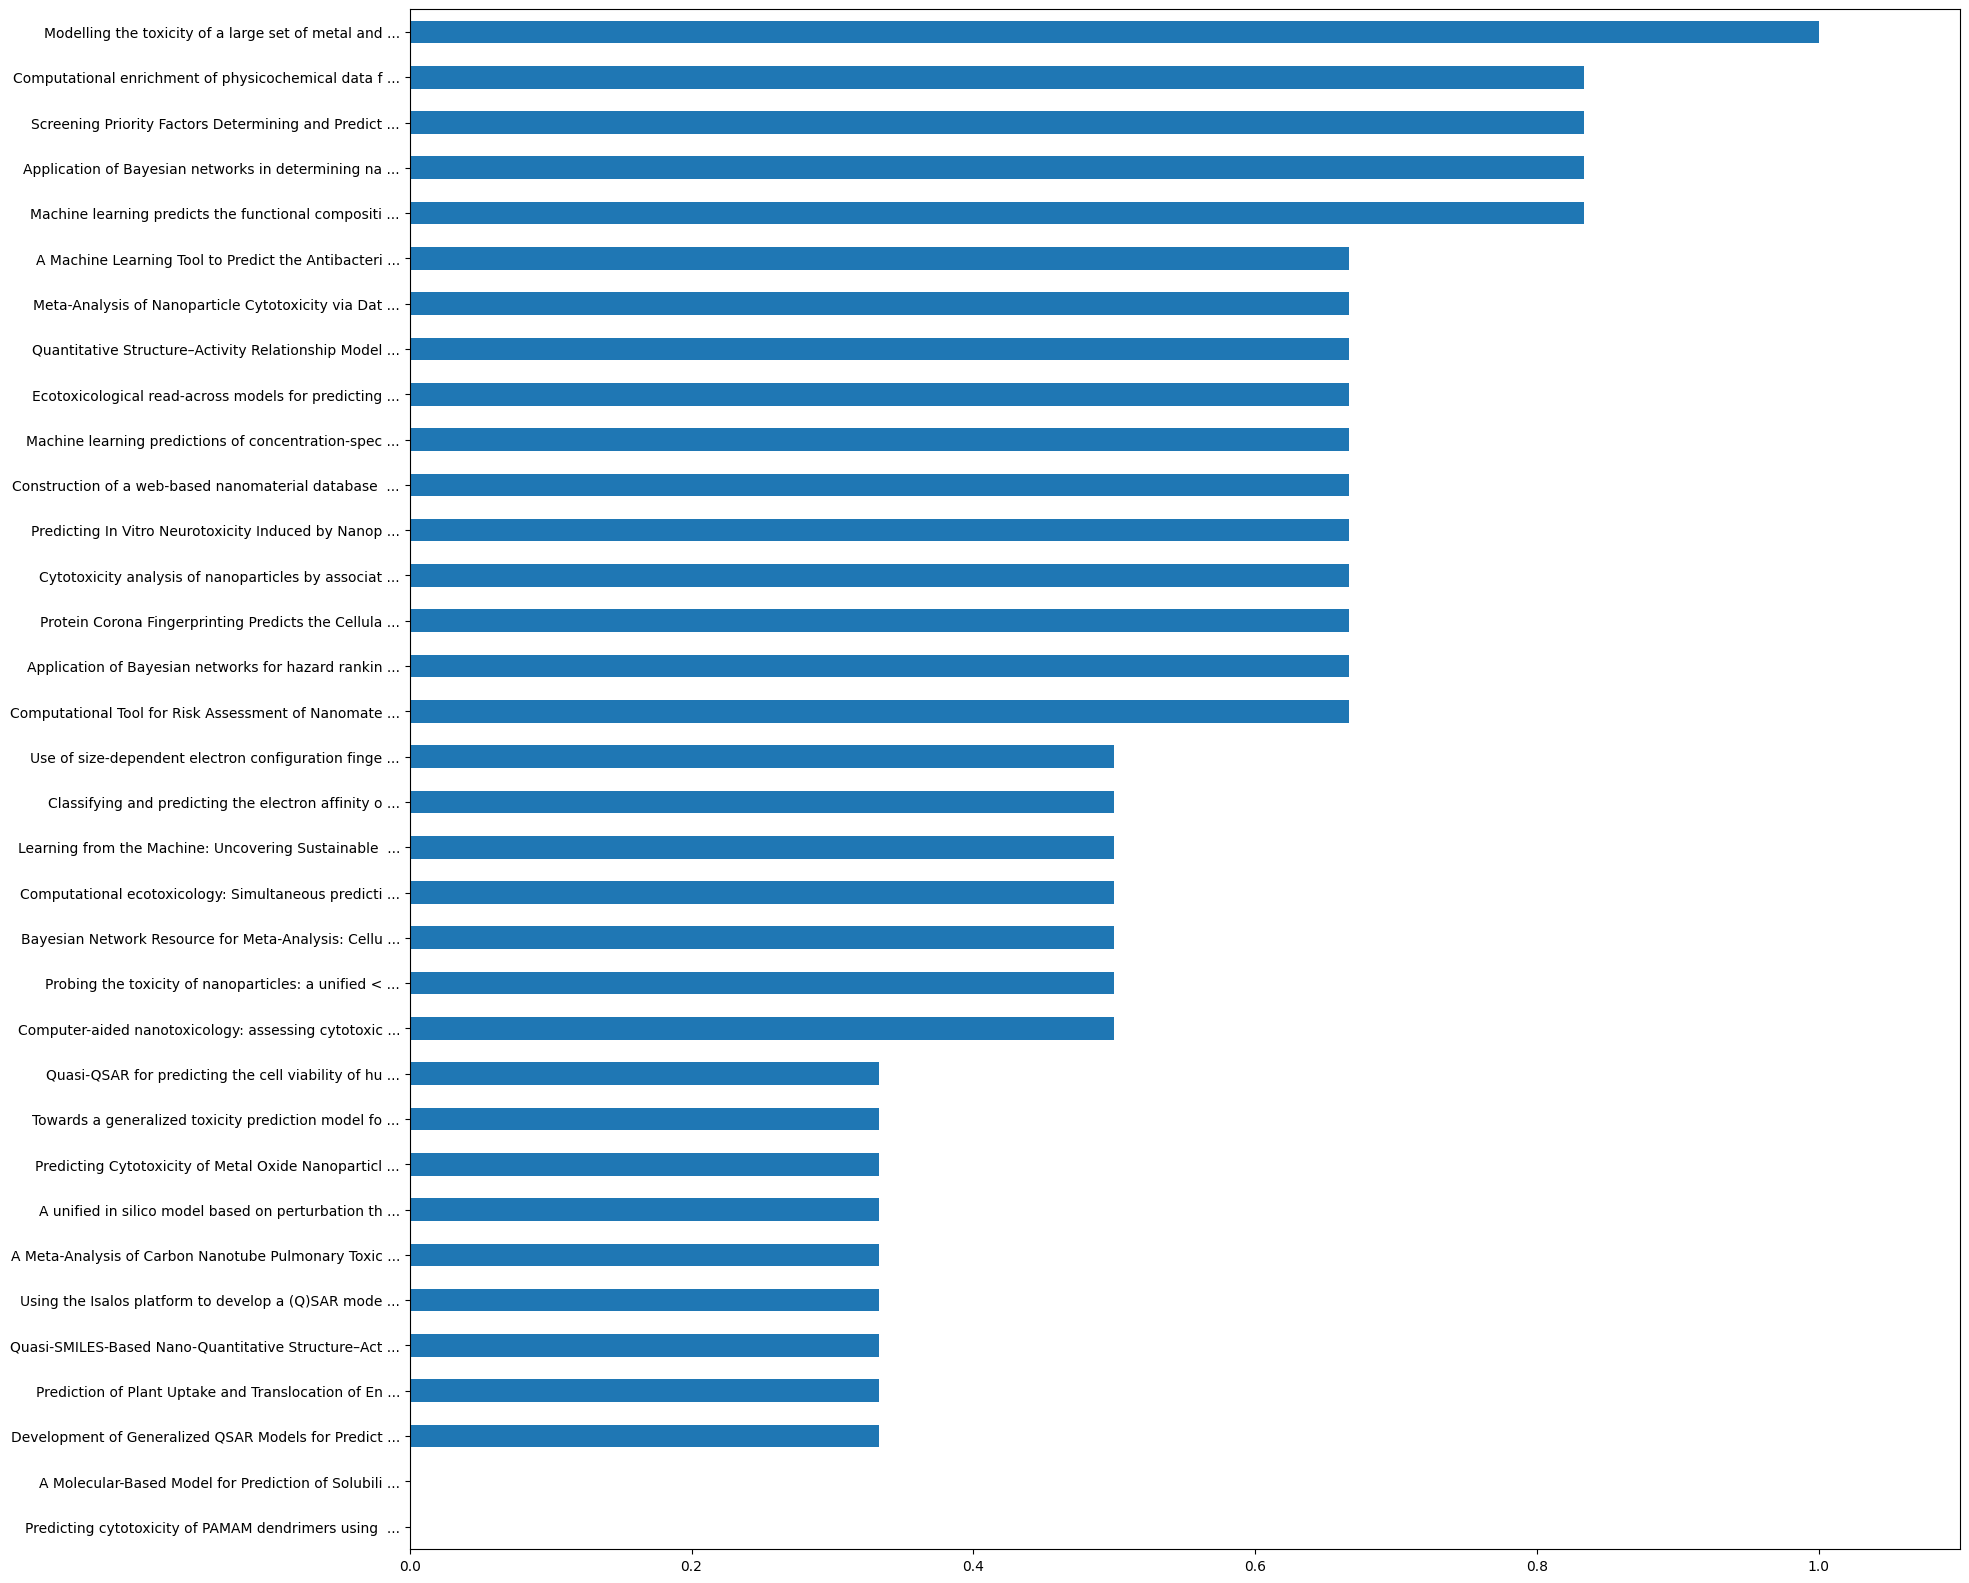

In [30]:
ax = data_df[applications[3]].sort_values().plot(kind='barh', xlim=(0.0, 1.1))
_ = ax.set_yticklabels(data_df.sort_values(applications[3])['title'].str[0:50]+" ...")

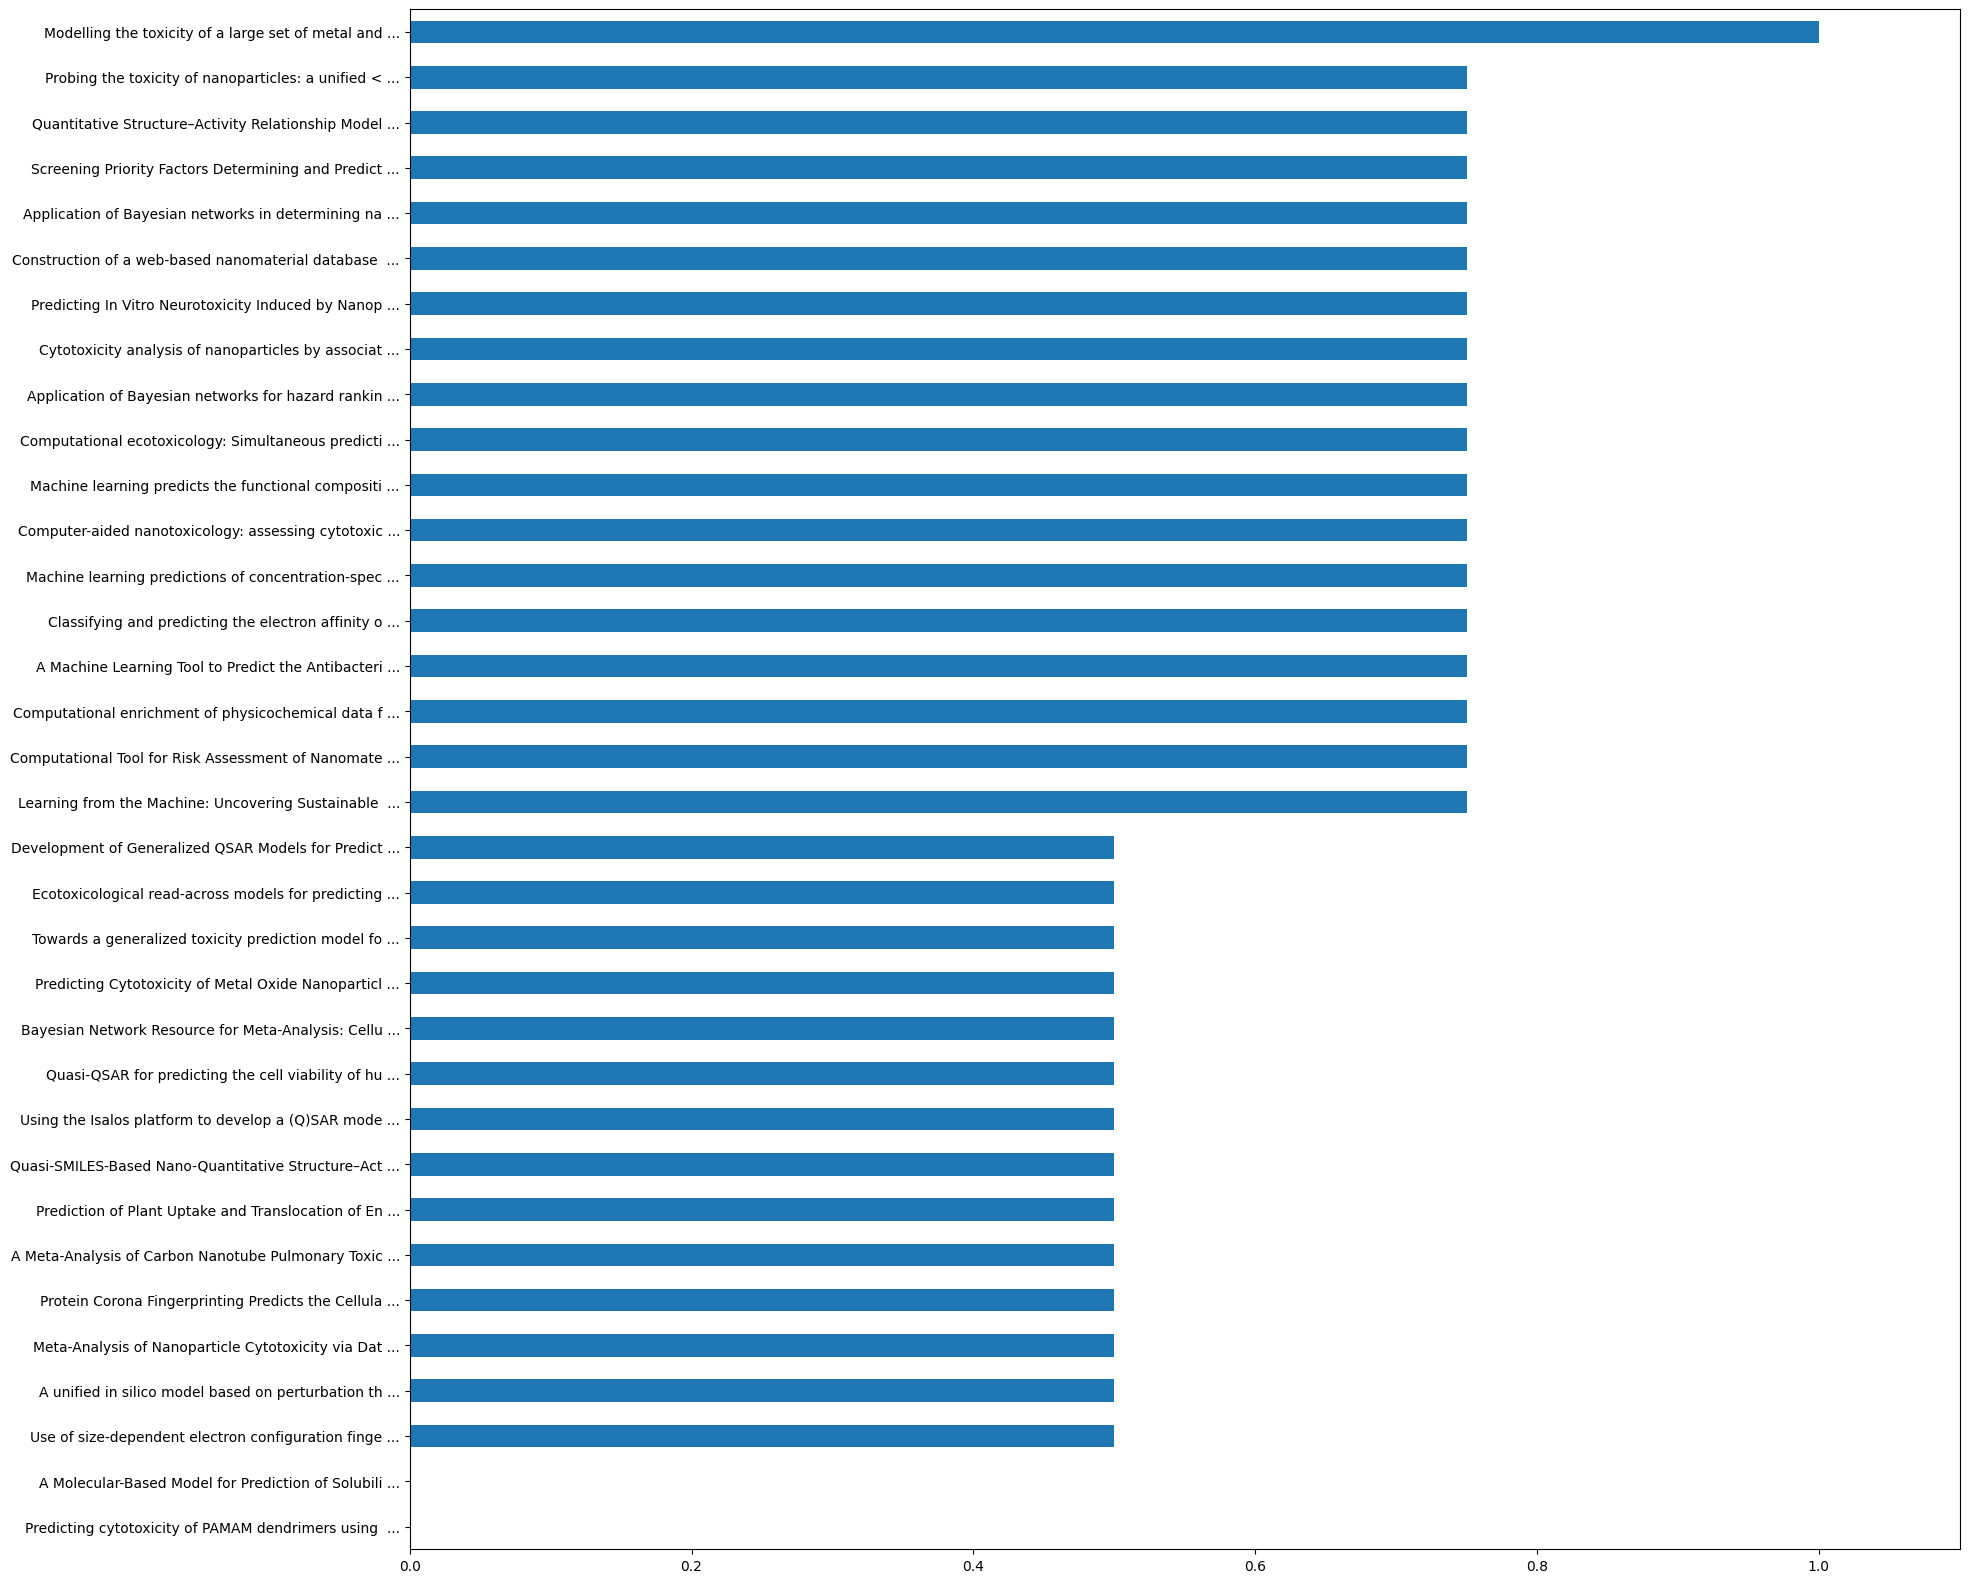

In [31]:
ax = data_df[applications[4]].sort_values().plot(kind='barh', xlim=(0.0, 1.1))
_ = ax.set_yticklabels(data_df.sort_values(applications[4])['title'].str[0:50]+" ...")

In [197]:
# generate sitemap.xml
from datetime import datetime
dateToday = datetime.today().strftime('%Y-%m-%d')

sitemap = """<?xml version="1.0" encoding="UTF-8"?>
<urlset xmlns="http://www.sitemaps.org/schemas/sitemap/0.9" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.sitemaps.org/schemas/sitemap/0.9 http://www.sitemaps.org/schemas/sitemap/0.9/sitemap.xsd">
"""

for i, row in dataset_desc.iterrows():
    sitemap = sitemap + """<url>
    <loc>https://ammar257ammar.github.io/Nanosafety-data-reusability-34-datasets/overview/"""+row["hash"][0:10]+""".html</loc>
    <lastmod>"""+dateToday+"""</lastmod>
    <changefreq>yearly</changefreq>
    <priority>1.0</priority>
</url>
"""
    
sitemap = sitemap + "</urlset>"

with open('sitemap.xml', 'w') as f:
    f.write(sitemap)